# 一.导入原始数据

## 1.数据导入和格式化

In [1]:
import torch
import pandas as pd
import os
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
from torch.nn.parallel import DataParallel
import torch.nn.functional as F
# 设定随机种子以保证结果可复现
torch.manual_seed(0)
np.random.seed(0)

# 设定设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 新数据
# 读取所有数据
paths = [
    'C:/Users/Administrator/Desktop/My research/2_ML_predict_product/data_product/1500K_3atm/clean_processed_data_1500_1.csv',
    'C:/Users/Administrator/Desktop/My research/2_ML_predict_product/data_product/1500K_3atm/clean_processed_data_1500_2.csv',
    'C:/Users/Administrator/Desktop/My research/2_ML_predict_product/data_product/1500K_3atm/clean_processed_data_1500_3.csv',
    'C:/Users/Administrator/Desktop/My research/2_ML_predict_product/data_product/1500K_3atm/clean_processed_data_1500_4.csv',
    'C:/Users/Administrator/Desktop/My research/2_ML_predict_product/data_product/1500K_3atm/clean_processed_data_1500_5.csv',
    'C:/Users/Administrator/Desktop/My research/2_ML_predict_product/data_product/1500K_3atm/clean_processed_data_1500_6.csv'
]
all_data = []
for path in paths:
    data = pd.read_csv(path,header=None)
    data = np.array(data)
    all_data.append(data)
all_data = np.concatenate(all_data, axis=0)

# 处理数据的函数
def process_data(data):
    pro_data = []
    for record in data:
        # 每条记录是一个字符串，将其按分号分割
        elements = record[0].split(';')
        processed_data = []
        for element in elements:
            # print(element)
            # 去除括号并按逗号分割成元素和数字
            mol, count = element.strip('()').split(',')
            processed_data.append((mol, int(count)))
        pro_data.append(np.array(processed_data))
    return pro_data

# 调用函数处理数据
processed = process_data(all_data) 
processed = np.array(processed, dtype=object)
print(processed.shape)
print(processed[0][:3])

(2658,)
[['Mo3O9' '55']
 ['MoO2' '18']
 ['MoO' '3']]


## 2.原始数据(processed)统计分析

In [14]:
# 统计所有物种类型
unique_species = set()

for record in processed:
    for element in record:
        # element 是一个包含 ['物种名称', '停留时间'] 的数组
        mol = element[0]  # 获取物种名称
        unique_species.add(mol)

# 输出所有物种类型的名称
print(len(unique_species))
#print(unique_species)

39


In [16]:
from collections import Counter
import numpy as np
import pandas as pd

def count_species_with_time(processed, n):
    """
    统计每个物种的总出现次数以及停留时间小于等于n的次数。

    参数:
    - processed (np.array): 处理后的数据数组，元素为每条记录的物种及停留时间。
    - n (int): 停留时间的阈值。

    返回:
    - species_counter (Counter): 每个物种的总出现次数。
    - species_counter_le_n (Counter): 每个物种停留时间小于等于n的出现次数。
    """
    species_counter = Counter()
    species_counter_le_n = Counter()
    
    for record in processed:
        for element in record:
            mol = element[0]
            try:
                count = int(element[1])
            except ValueError:
                print(f"无法将停留时间转换为整数: {element[1]}，跳过该元素。")
                continue  # 跳过无法转换的元素
            
            species_counter[mol] += 1
            if count <= n:
                species_counter_le_n[mol] += 1
    
    return species_counter, species_counter_le_n

def print_species_statistics(species_counts, species_counts_le_n, n):
    """
    打印每种物种的总出现次数、停留时间小于等于n的出现次数以及停留时间大于n的出现次数，
    按总出现次数降序排列。

    参数:
    - species_counts (Counter): 每个物种的总出现次数。
    - species_counts_le_n (Counter): 每个物种停留时间小于等于n的出现次数。
    - n (int): 停留时间的阈值。
    """
    # 获取按总出现次数降序排列的物种列表
    sorted_species = species_counts.most_common()
    
    # 打印表头
    print(f"\n{'物种类型':<20} {'总出现次数':<15} {'停留时间<= ' + str(n) + ' 次数':<20} {'停留时间> ' + str(n) + ' 次数':<20}")
    print("-" * 75)
    
    # 打印每种物种的统计数据
    for mol, total in sorted_species:
        le_n = species_counts_le_n.get(mol, 0)
        gt_n = total - le_n  # 计算停留时间 > n 的次数
        print(f"{mol:<20} {total:<15} {le_n:<20} {gt_n:<20}")


# 示例调用
if __name__ == "__main__":

    n = 10  # 设定阈值
    
    # 统计物种出现次数和停留时间小于等于n的出现次数
    species_counts, species_counts_le_n = count_species_with_time(processed, n)
    
    # 打印统计结果，按总出现次数降序排列
    print_species_statistics(species_counts, species_counts_le_n, n)


物种类型                 总出现次数           停留时间<= 10 次数         停留时间> 10 次数         
---------------------------------------------------------------------------
MoS5                 63174           50439                12735               
MoS6                 57354           7585                 49769               
MoOS6                35272           4826                 30446               
MoS4                 33365           24494                8871                
MoS7                 27551           3508                 24043               
MoS8                 27438           9756                 17682               
MoO2S5               22761           7726                 15035               
MoOS5                22472           4317                 18155               
MoS9                 16737           10548                6189                
MoOS7                15215           8336                 6879                
MoS3                 10019           4178             

In [5]:
from collections import Counter, defaultdict
# -----------------------------------------------
# 统计每个物种的最大、最小和平均停留时间
# -----------------------------------------------

# 使用 defaultdict 存储每个物种的最小、最大停留时间及总停留时间
species_time_stats = defaultdict(lambda: {'min': None, 'max': None, 'total': 0, 'count': 0})

for record in processed:
    for element in record:
        mol, count = element[0], int(element[1])
        if species_time_stats[mol]['min'] is None or count < species_time_stats[mol]['min']:
            species_time_stats[mol]['min'] = count
        if species_time_stats[mol]['max'] is None or count > species_time_stats[mol]['max']:
            species_time_stats[mol]['max'] = count
        species_time_stats[mol]['total'] += count
        species_time_stats[mol]['count'] += 1

# 计算平均停留时间并准备输出列表
species_time_list = sorted(
    [
        (
            stats['total'] / stats['count'] if stats['count'] > 0 else 0,
            stats['max'],
            stats['min'],
            mol
        )
        for mol, stats in species_time_stats.items()
    ],
    key=lambda x: x[0]
)

# 输出统计结果
print("\n每种物种类型的最大、最小和平均停留时间：")
for avg_time, max_time,min_time,mol in species_time_list:
    print(f"{mol}: 最小停留时间 = {min_time}, 最大停留时间 = {max_time}, 平均停留时间 = {avg_time:.2f}")


每种物种类型的最大、最小和平均停留时间：
Mo2O4: 最小停留时间 = 1, 最大停留时间 = 69, 平均停留时间 = 4.71
Mo2O3: 最小停留时间 = 1, 最大停留时间 = 26, 平均停留时间 = 6.44
MoO3: 最小停留时间 = 1, 最大停留时间 = 473, 平均停留时间 = 8.19
Mo2OS: 最小停留时间 = 1, 最大停留时间 = 43, 平均停留时间 = 9.71
Mo3O9S2: 最小停留时间 = 1, 最大停留时间 = 62, 平均停留时间 = 11.20
Mo2O2: 最小停留时间 = 1, 最大停留时间 = 62, 平均停留时间 = 13.27
MoO2S2: 最小停留时间 = 1, 最大停留时间 = 730, 平均停留时间 = 14.52
MoO2S3: 最小停留时间 = 1, 最大停留时间 = 459, 平均停留时间 = 16.78
MoO2S: 最小停留时间 = 1, 最大停留时间 = 604, 平均停留时间 = 16.85
MoS9: 最小停留时间 = 1, 最大停留时间 = 1877, 平均停留时间 = 20.44
MoO2S4: 最小停留时间 = 1, 最大停留时间 = 1976, 平均停留时间 = 26.09
MoOS7: 最小停留时间 = 1, 最大停留时间 = 1588, 平均停留时间 = 29.29
MoO2S6: 最小停留时间 = 1, 最大停留时间 = 405, 平均停留时间 = 30.13
MoS5: 最小停留时间 = 1, 最大停留时间 = 2017, 平均停留时间 = 36.85
MoOS4: 最小停留时间 = 1, 最大停留时间 = 1124, 平均停留时间 = 37.73
Mo: 最小停留时间 = 1, 最大停留时间 = 544, 平均停留时间 = 38.35
MoO2S5: 最小停留时间 = 1, 最大停留时间 = 1414, 平均停留时间 = 41.01
MoS4: 最小停留时间 = 1, 最大停留时间 = 2915, 平均停留时间 = 41.34
MoOS2: 最小停留时间 = 1, 最大停留时间 = 1242, 平均停留时间 = 42.33
MoO2: 最小停留时间 = 1, 最大停留时间 = 665, 平均停留时间 = 44.40
MoS: 最小停留时间 = 1, 最大停

## 3.深度过滤原始数据(processed)

In [2]:
import numpy as np

def filter_and_merge_one_record(record, min_time=5):
    """
    对单条记录进行过滤和合并操作：
    1. 删除停留时间小于 min_time 的状态。
    2. 将删除后连续且相同物种的状态合并为一个状态（停留时间累加）。
    
    参数：
    - record: 形如 array([['MoO','33'], ['MoS','251'], ['MoS','254'], ...]) 的数组
    - min_time: 停留时间的阈值，删除停留时间小于该值的状态
    
    返回：
    - 处理后的 NumPy 数组，满足以上两步操作
    """
    # 1) 过滤：删除停留时间 < min_time 的状态
    filtered = [row for row in record if int(row[1]) >= min_time]
    
    # 2) 合并连续相同物种的状态
    merged = []
    for mol, time_str in filtered:
        time_val = int(time_str)
        if merged and merged[-1][0] == mol:
            # 若与上一个物种相同，则合并（累加停留时间）
            merged[-1][1] = str(int(merged[-1][1]) + time_val)
        else:
            # 否则添加新的物种状态
            merged.append([mol, str(time_val)])
    
    return np.array(merged)

def filter_and_merge_processed(processed, min_time=5):
    """
    对完整的 processed 数据进行过滤和合并操作：
    对 processed 每个元素（单条记录）调用 filter_and_merge_one_record
    
    参数：
    - processed: 形如 [record_1, record_2, ...] 的对象数组（dtype=object）
    - min_time: 停留时间的阈值
    
    返回：
    - 处理后的 NumPy 对象数组
    """
    new_processed = []
    for idx, record in enumerate(processed):
        merged_record = filter_and_merge_one_record(record, min_time=min_time)
        new_processed.append(merged_record)
    
    return np.array(new_processed, dtype=object)

# -------------------- 测试示例 --------------------
if __name__ == "__main__":    
    # 设定阈值，比如 n=5
    n = 5
    
    # 调用过滤和合并函数
    new_processed = filter_and_merge_processed(processed, min_time=n)
    
    # 打印过滤前和过滤后的结果
    print("过滤前 (原始数据) ：")
    print(processed[3][:10])
    
    print("\n过滤后 (删除停留时间 < 5 并合并相邻相同状态) ：")
    print(new_processed[3][:10])

过滤前 (原始数据) ：
[['Mo3O9' '26']
 ['Mo3O9S2' '11']
 ['MoO3' '2']
 ['MoO2' '96']
 ['MoO2S2' '2']
 ['MoOS' '102']
 ['MoOS3' '8']
 ['MoS2' '20']
 ['MoS4' '4']
 ['MoS2' '76']]

过滤后 (删除停留时间 < 5 并合并相邻相同状态) ：
[['Mo3O9' '26']
 ['Mo3O9S2' '11']
 ['MoO2' '96']
 ['MoOS' '102']
 ['MoOS3' '8']
 ['MoS2' '96']
 ['MoOS2' '5']
 ['MoS' '232']
 ['MoS2' '80']
 ['MoS4' '14']]


# 二.数据编码

## 编码方式1 - [ 3, 9, 0, 55],得到cy_data

In [4]:
# 编码，转换成向量
def incode(molecule):
    vec = np.zeros(3)
    length = len(molecule)
    Mo = molecule.find('Mo')
    O = molecule.find('O')
    S = molecule.find('S')
    # print(Mo, O, S)
    moi = oi = si = 0
    moi = 1
    if O==-1 and S==-1 and length>2:
        moi = molecule[Mo+2:]
    elif O != -1:
        if O > Mo + 2:
            moi = int(molecule[Mo+2:O])
        else:
            moi = 1
        if S == O + 1 or O+1==length:
            oi = 1
        elif S==-1:
            oi = int(molecule[O+1:])
        else:
            oi = int(molecule[O+1:S])
    elif S != -1:
        if S > Mo + 2:
            moi = int(molecule[Mo+2:S])
        else:
            moi = 1
        if S+1==length:
            si = 1
        else:
            si = int(molecule[S+1:])
    if S!=-1:
        if S+1==length:
            si = 1
        else:
            si = int(molecule[S+1:])
    vec = np.array([moi, oi, si])
    return vec
incode('MoOS13')

array([ 1,  1, 13])

对processed或new_processed进行编码

In [5]:
# 使用列表推导式遍历二维数组并调用函数进行编码，将返回值存储在新的二维数组中
cy_data = new_processed #使用深度处理后的数据
cy_data = [[np.append(incode(value[0]), int(value[1])) for value in row] for row in cy_data]
cy_data = np.array(cy_data,dtype=object)
print(cy_data.shape)
cy_data[0][:5]

(2658,)


[array([ 3,  9,  0, 55]),
 array([ 1,  2,  0, 18]),
 array([ 1,  0,  1, 10]),
 array([  1,   0,   3, 159]),
 array([ 1,  1,  4, 20])]

## 编码方式2 - [37 55] [类别编号,时间],得到cy_data_encoded --备注:先执行编码方式1

In [6]:
# 在现有代码基础上添加以下部分
from sklearn.preprocessing import LabelEncoder
import joblib  # 用于保存编码器

# ====== 新增函数：将Mo/O/S组合编码为唯一类别 ======
def encode_mo_os_combinations(cy_data):
    """将每个[Mo, O, S]组合编码为唯一整数类别"""
    # 提取所有Mo/O/S组合
    all_combinations = []
    for row in cy_data:
        for state in row:
            mo_os = tuple(state[:3])  # 前三个元素为Mo/O/S原子数
            all_combinations.append(mo_os)
    
    # 训练编码器
    encoder = LabelEncoder()
    # 将组合转换为字符串（例如 (3,9,0) -> "3_9_0"）
    str_combinations = ["_".join(map(str, comb)) for comb in all_combinations]
    encoder.fit(str_combinations)
    
    # 替换原始数据中的前3列为编码后的类别
    encoded_cy_data = []
    for row in cy_data:
        encoded_row = []
        for state in row:
            mo_os_str = "_".join(map(str, state[:3]))
            encoded_label = encoder.transform([mo_os_str])[0]
            # 新数据格式：[encoded_label, time]
            encoded_row.append([encoded_label, state[3]])
        encoded_cy_data.append(np.array(encoded_row))
    
    return np.array(encoded_cy_data, dtype=object), encoder

# 执行编码
cy_data_encoded, state_encoder = encode_mo_os_combinations(cy_data)

# 保存编码器（用于后续推理）
joblib.dump(state_encoder, 'state_encoder.pkl')

# 检查编码后数据格式
print("编码后数据示例：")
print(cy_data_encoded[0][0])  # 应输出类似 [5, 50]（类别索引, 时间）

编码后数据示例：
[37 55]


In [7]:
print("所有物种类型的数量：",len(state_encoder.classes_))
state_encoder.classes_

所有物种类型的数量： 39


array(['1_0_0', '1_0_1', '1_0_2', '1_0_3', '1_0_4', '1_0_5', '1_0_6',
       '1_0_7', '1_0_8', '1_0_9', '1_1_0', '1_1_1', '1_1_2', '1_1_3',
       '1_1_4', '1_1_5', '1_1_6', '1_1_7', '1_2_0', '1_2_1', '1_2_2',
       '1_2_3', '1_2_4', '1_2_5', '1_2_6', '1_3_0', '2_0_10', '2_0_4',
       '2_0_5', '2_0_6', '2_0_7', '2_0_8', '2_0_9', '2_1_1', '2_2_0',
       '2_3_0', '2_4_0', '3_9_0', '3_9_2'], dtype='<U6')

In [8]:
# 获取 state_encoder.classes_ 的内容
classes = state_encoder.classes_

# 输出每个物种的编号及其对应的名称
print("物种编号及对应的物种名称：")
for idx, class_name in enumerate(classes):
    print(f"类别 {idx}: {class_name}")

物种编号及对应的物种名称：
类别 0: 1_0_0
类别 1: 1_0_1
类别 2: 1_0_2
类别 3: 1_0_3
类别 4: 1_0_4
类别 5: 1_0_5
类别 6: 1_0_6
类别 7: 1_0_7
类别 8: 1_0_8
类别 9: 1_0_9
类别 10: 1_1_0
类别 11: 1_1_1
类别 12: 1_1_2
类别 13: 1_1_3
类别 14: 1_1_4
类别 15: 1_1_5
类别 16: 1_1_6
类别 17: 1_1_7
类别 18: 1_2_0
类别 19: 1_2_1
类别 20: 1_2_2
类别 21: 1_2_3
类别 22: 1_2_4
类别 23: 1_2_5
类别 24: 1_2_6
类别 25: 1_3_0
类别 26: 2_0_10
类别 27: 2_0_4
类别 28: 2_0_5
类别 29: 2_0_6
类别 30: 2_0_7
类别 31: 2_0_8
类别 32: 2_0_9
类别 33: 2_1_1
类别 34: 2_2_0
类别 35: 2_3_0
类别 36: 2_4_0
类别 37: 3_9_0
类别 38: 3_9_2


# 三.构建数据集

## 3.1.设计X和y & 划分数据集(对cy_data和cy_data_encoded进行处理)

### 1.1. 针对单输出回归任务设计x和y ,且x,y的特征均为4(针对cy_data进行设计)

In [ ]:
import numpy as np
from tqdm import tqdm

# 构建数据集
def create_dataset(data, sequence_length):
    """
    将输入数据分割为长度为 sequence_length 的序列。
    """
    sequences = []
    for i in range(len(data) - sequence_length): #窗口是一个一个推后,所以如果一行原本有110组数据,那么就会产生110-sequence_length+1个 窗格
        # 构建序列
        sequences.append(data[i:i + sequence_length])
    return sequences

# 参数
sequence_length = 3

sequences = []
X = []
y = []
for row in cy_data:
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    sequences.append(sequence)
    X.append(sequence[:-1])  # 除去最后一个序列
    y.append(sequence[1:, -1])  # 没有问题，因为连续的sequence之间中间段本来就相同

sequences = np.array(sequences,dtype=object)
X = np.array(X,dtype=object)
y = np.array(y,dtype=object)
# 检查生成的序列形状
print('sequences.shape', sequences.shape)

# 构建输入 X 和输出 y

print('X.shape', X.shape)  # 输入的形状
print('y.shape', y.shape)  # 输出的形状
print(X[0][:3])
print(y[0][:2])

In [ ]:
# 将数据划分为训练集和测试集，可以指定测试集的大小和随机种子
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train.shape', X_train.shape,'X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape,'y_test.shape', y_test.shape)
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)
print('X_train.shape', X_train.shape,'X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape,'y_test.shape', y_test.shape)

### 1.2.针对单输出回归任务设计x和y ,且x,y的特征分别为4和1(时间)(针对cy_data进行设计)

In [ ]:
import numpy as np
from tqdm import tqdm

# 构建数据集
def create_dataset(data, sequence_length):
    """
    将输入数据分割为长度为 sequence_length 的序列。
    """
    sequences = []
    for i in range(len(data) - sequence_length): #窗口是一个一个推后,所以如果一行原本有110组数据,那么就会产生110-sequence_length+1个 窗格
        # 构建序列
        sequences.append(data[i:i + sequence_length])
    return sequences

# 参数
sequence_length = 3

sequences = []
X = []
y = []
for row in cy_data:
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    sequences.append(sequence)
    X.append(sequence[:-1])  # 除去最后一个序列
    y.append(sequence[1:, -1])  # 没有问题，因为连续的sequence之间中间段本来就相同

sequences = np.array(sequences,dtype=object)
X = np.array(X,dtype=object)
y = np.array(y,dtype=object)



# 将数据划分为训练集和测试集，可以指定测试集的大小和随机种子
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)


# 将x_train和y_train接起来####################把y原本的特征接到了X上,比sequence多一个维度.
y_train_expanded = np.expand_dims(y_train, axis=1)  # 将 y_train 从 (n, 4) 转换为 (n, 1, 4)
train_data = np.concatenate((X_train, y_train_expanded), axis=1)

# 将x_test和y_test接起来
y_test_expanded = np.expand_dims(y_test, axis=1)  # 将 y_test 从 (n, 4) 转换为 (n, 1, 4)
test_data = np.concatenate((X_test, y_test_expanded), axis=1)


train_data[:, -1, -1] = 0 #将训练数据中的y值中的时间部分转变为0
test_data[:, -1, -1] = 0

X_train = train_data  #输入变成了11维,并且强行将最后一维度的时间变为0
X_test = test_data
print(X_train.shape)
print(X_test.shape)

y_train = y_train[:, 3]#n行，1列，及一个X矩阵预测一个值
y_test = y_test[:, 3]
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
print(y_train.shape)
print(y_test.shape)

### 1.3 针对单输出分类任务设计x和y,并且x和y只包含物种类别一个特征 (针对cy_data_encoded进行设计)¶

In [19]:
import numpy as np
from tqdm import tqdm

# 构建数据集
def create_dataset(data, sequence_length):
    """
    将输入数据分割为长度为 sequence_length 的序列。
    """
    sequences = []
    for i in range(len(data) - sequence_length): #窗口是一个一个推后,所以如果一行原本有110组数据,那么就会产生110-sequence_length+1个 窗格
        # 构建序列
        sequences.append(data[i:i + sequence_length])
    return sequences

# 参数
sequence_length = 5

sequences = []
X = []
y = []
for row in cy_data_encoded:
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    sequences.append(sequence)
    X.append(sequence[:-1,:, 0].reshape(-1,sequence_length,1))  # 除去最后一个序列,并且只取状态
    y.append(sequence[1:, -1,0].reshape(-1,1))   # 除去第一个序列,并且只取状态

sequences = np.array(sequences,dtype=object)
X = np.array(X,dtype=object)
y = np.array(y,dtype=object)

# 将数据划分为训练集和测试集，可以指定测试集的大小和随机种子
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)




# 获取训练集和测试集中的唯一类别
unique_train_classes = np.unique(y_train)
unique_test_classes = np.unique(y_test)

# 获取总的类别范围（通过 state_encoder 的类别总数）
total_classes = np.arange(len(state_encoder.classes_))

# 统计训练集和测试集中的类别数量
num_train_classes = len(unique_train_classes)
num_test_classes = len(unique_test_classes)


# 检查训练集中是否缺少某些类别
missing_classes_in_train = set(total_classes) - set(unique_train_classes)
# 检查测试集中是否缺少某些类别
missing_classes_in_test = set(total_classes) - set(unique_test_classes)



# 输出结果
print(f"训练集中包含的类别数量: {num_train_classes}")
print(f"测试集中包含的类别数量: {num_test_classes}")
print(f"总类别数量: {len(total_classes)}")

if missing_classes_in_train:
    print(f"训练集中缺失的类别: {missing_classes_in_train}")
else:
    print("训练集中没有缺失任何类别。")


if missing_classes_in_test:
    print(f"测试集中缺失的类别: {missing_classes_in_test}")
else:
    print("测试集中没有缺失任何类别。")

(1860,) (798,)
(1860,) (798,)
(132480, 5, 1) (56761, 5, 1)
(132480, 1) (56761, 1)
训练集中包含的类别数量: 35
测试集中包含的类别数量: 35
总类别数量: 39
训练集中缺失的类别: {35, 36, 37, 38}
测试集中缺失的类别: {35, 36, 37, 38}


In [20]:
# 获取 state_encoder.classes_ 的内容
classes = state_encoder.classes_

# 定义需要查询的类别索引
target_indices = [35, 37, 38]

# 输出对应的物种名称
print("类别索引对应的物种名称：")
for idx in target_indices:
    if idx < len(classes):  # 确保索引在范围内
        print(f"类别 {idx}: {classes[idx]}")
    else:
        print(f"类别 {idx} 超出了范围，无法找到对应物种。")

类别索引对应的物种名称：
类别 35: 2_3_0
类别 37: 3_9_0
类别 38: 3_9_2


### 2.针对多输出(分类+回归)任务,设计X和y1,y2 (针对cy_data_encoded进行设计)

In [83]:
# 构建数据集
def create_dataset(data, sequence_length):
    """
    将输入数据分割为长度为 sequence_length 的序列。
    """
    sequences = []
    for i in range(len(data) - sequence_length): #窗口是一个一个推后,所以如果一行原本有110组数据,那么就会产生110-sequence_length+1个 窗格
        # 构建序列
        sequences.append(data[i:i + sequence_length])
    return sequences

# 参数
sequence_length = 3

sequences = []
# 构建输入 X 和输出 y
X = []       # 输入序列：形状 (n_samples, sequence_length, 2)
y_state = [] # 目标状态类别：形状 (n_samples,)
y_time = []  # 目标时间：形状 (n_samples,)
for row in cy_data_encoded:
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    
    sequences.append(sequence)
    X.append(sequence[:-1])  # 除去最后一个序列
    y_state.append(sequence[1:, -1][:,0])  # 没有问题，因为连续的sequence之间中间段本来就相同
    y_time.append(sequence[1:, -1][:,1])  
    
sequences = np.array(sequences,dtype=object)
X = np.array(X,dtype=object)
y_state = np.array(y_state,dtype=object)    
y_time = np.array(y_time,dtype=object)    

# 检查生成的序列形状
print('sequences.shape', sequences.shape)
print('X.shape', X.shape)  # 输入的形状
print('y_state', y_state.shape)  # 输出的形状
print('y_time', y_time.shape)  # 输出的形状
print(X[0][:3])
print(y_state[0][:2])   
print(y_time[0][:2])

sequences.shape (2658,)
X.shape (2658,)
y_state (2658,)
y_time (2658,)
[[[ 37  55]
  [ 18  18]
  [ 10   3]]

 [[ 18  18]
  [ 10   3]
  [  1  10]]

 [[ 10   3]
  [  1  10]
  [  3 159]]]
[1 3]
[ 10 159]


In [10]:
# 将数据划分为训练集和测试集，可以指定测试集的大小和随机种子
# 同时保持三个部分的对应关系
X_train, X_test, y_state_train, y_state_test, y_time_train, y_time_test = train_test_split(
    X, y_state, y_time, 
    test_size=0.3, 
    random_state=42
)
print(X_train.shape,y_state_train.shape, y_time_train.shape)
print(X_test.shape,y_state_test.shape, y_time_test.shape)

X_train = np.concatenate(X_train)
y_state_train = np.concatenate(y_state_train)
y_time_train = np.concatenate(y_time_train)

X_test = np.concatenate(X_test)
y_state_test = np.concatenate(y_state_test)
y_time_test = np.concatenate(y_time_test)
print('X_train.shape', X_train.shape,'X_test.shape', X_test.shape)
print('y_state_train.shape', y_state_train.shape,'y_state_test.shape',y_state_test.shape)
print('y_time_train.shape', y_time_train.shape,'y_time_test.shape',y_time_test.shape)

(1860,) (1860,) (1860,)
(798,) (798,) (798,)
X_train.shape (284855, 2, 2) X_test.shape (122888, 2, 2)
y_state_train.shape (284855,) y_state_test.shape (122888,)
y_time_train.shape (284855,) y_time_test.shape (122888,)


## 3.2 对数据集进行特征处理

### 1.1. 针对单输出任务,x,y的特征均为4的数据集进行特征处理

#### a.对前三维特征进行标准化处理,对第4维特征进行取对数处理

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# 假设你的训练集和测试集是 X_train 和 X_test
# X_train 和 X_test 形状为 (n_samples, 10, 4)

# 提取前三个特征（前3列）
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# 提取第四个特征（第4列）
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# 标准化前三个特征，标准化特征可以使得数据不会受到某个特征由于数值范围与其它特征的数值范围差别较大而导致对于模型对于特征敏感度的影响
X_scaler = StandardScaler()
X_train_features_3 = X_scaler.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = X_scaler.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)
# 对第四个特征取对数（确保数值大于0）
X_train_feature_4 = np.log(X_train_feature_4) 
X_test_feature_4 = np.log(X_test_feature_4)

# 合并处理后的特征
X_train_processed = np.concatenate([X_train_features_3, X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_feature_4[..., np.newaxis]], axis=-1)





# 提取前三个特征（前3列）
y_train_features_3 = y_train[:, :3]
y_test_features_3 = y_test[:, :3]

# 提取第四个特征（第4列）
y_train_feature_4 = y_train[:, 3]
y_test_feature_4 = y_test[:, 3]

# 标准化前三个特征，标准化特征可以使得数据不会受到某个特征由于数值范围与其它特征的数值范围差别较大而导致对于模型对于特征敏感度的影响
y_scaler = StandardScaler()
y_train_features_3 = y_scaler.fit_transform(y_train_features_3.reshape(-1, 3)).reshape(y_train_features_3.shape)
y_test_features_3 = y_scaler.transform(y_test_features_3.reshape(-1, 3)).reshape(y_test_features_3.shape)

# 对第四个特征取对数（确保数值大于0）
y_train_feature_4 = np.log(y_train_feature_4) 
y_test_feature_4 = np.log(y_test_feature_4)

# 合并处理后的特征
y_train_processed = np.concatenate([y_train_features_3, y_train_feature_4[..., np.newaxis]], axis=-1)
y_test_processed = np.concatenate([y_test_features_3, y_test_feature_4[..., np.newaxis]], axis=-1)

# 检查结果
print(X_train_processed.shape)  # 应该是 (89204, 10, 4) #如果是分子状态和停留时间同时预测
print(X_test_processed.shape)   # 应该是 (38902, 10, 4)



# 检查结果
print(y_train_processed.shape)  # 应该是 (89204, 4)
print(y_test_processed.shape)   # 应该是 (38902, 4)

In [ ]:
#将数据进一步转换成深度学习框架需要的张量tensor形式
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))

test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))

#### b.对前三维特征进行标准化处理,对第4维特征不处理

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# 假设你的训练集和测试集是 X_train 和 X_test
# X_train 和 X_test 形状为 (n_samples, 10, 4)

# 提取前三个特征（前3列）
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# 提取第四个特征（第4列）
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# 标准化前三个特征，标准化特征可以使得数据不会受到某个特征由于数值范围与其它特征的数值范围差别较大而导致对于模型对于特征敏感度的影响
X_scaler = StandardScaler()
X_train_features_3 = X_scaler.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = X_scaler.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)

# 对第四个特征不做处理
X_train_feature_4 = X_train_feature_4 
X_test_feature_4 = X_test_feature_4

# 合并处理后的特征
X_train_processed = np.concatenate([X_train_features_3, X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_feature_4[..., np.newaxis]], axis=-1)





# 提取前三个特征（前3列）
y_train_features_3 = y_train[:, :3]
y_test_features_3 = y_test[:, :3]

# 提取第四个特征（第4列）
y_train_feature_4 = y_train[:, 3]
y_test_feature_4 = y_test[:, 3]

# 标准化前三个特征，标准化特征可以使得数据不会受到某个特征由于数值范围与其它特征的数值范围差别较大而导致对于模型对于特征敏感度的影响
y_scaler = StandardScaler()
y_train_features_3 = y_scaler.fit_transform(y_train_features_3.reshape(-1, 3)).reshape(y_train_features_3.shape)
y_test_features_3 = y_scaler.transform(y_test_features_3.reshape(-1, 3)).reshape(y_test_features_3.shape)

# 对第四个特征不做处理
y_train_feature_4 = y_train_feature_4
y_test_feature_4 = y_test_feature_4

# 合并处理后的特征
y_train_processed = np.concatenate([y_train_features_3, y_train_feature_4[..., np.newaxis]], axis=-1)
y_test_processed = np.concatenate([y_test_features_3, y_test_feature_4[..., np.newaxis]], axis=-1)

# 检查结果
print(X_train_processed.shape)  # 应该是 (89204, 10, 4) #如果是分子状态和停留时间同时预测
print(X_test_processed.shape)   # 应该是 (38902, 10, 4)



# 检查结果
print(y_train_processed.shape)  # 应该是 (89204, 4)
print(y_test_processed.shape)   # 应该是 (38902, 4)

In [ ]:
#将数据进一步转换成深度学习框架需要的张量tensor形式
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))

test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))

#### c.对前四个维特征进行标准化处理

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# 假设你的训练集和测试集是 X_train 和 X_test
# X_train 和 X_test 形状为 (n_samples, 10, 4)

# 提取前三个特征（前3列）
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# 提取第四个特征（第4列）
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# 标准化前三个特征，标准化特征可以使得数据不会受到某个特征由于数值范围与其它特征的数值范围差别较大而导致对于模型对于特征敏感度的影响
X1_scaler = StandardScaler()
X_train_features_3 = X1_scaler.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = X1_scaler.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)

# 对第四个特征也进行scaler处理
X2_scaler = StandardScaler()
X_train_features_4 = X2_scaler.fit_transform(X_train_feature_4.reshape(-1, 1)).reshape(X_train_feature_4.shape)
X_test_features_4 = X2_scaler.transform(X_test_feature_4.reshape(-1, 1)).reshape(X_test_feature_4.shape)

# 合并处理后的特征
X_train_processed = np.concatenate([X_train_features_3, X_train_features_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_features_4[..., np.newaxis]], axis=-1)



# 提取前三个特征（前3列）
y_train_features_3 = y_train[:, :3]
y_test_features_3 = y_test[:, :3]

# 提取第四个特征（第4列）
y_train_feature_4 = y_train[:, 3]
y_test_feature_4 = y_test[:, 3]

# 标准化前三个特征，标准化特征可以使得数据不会受到某个特征由于数值范围与其它特征的数值范围差别较大而导致对于模型对于特征敏感度的影响
y1_scaler = StandardScaler()
y_train_features_3 = y1_scaler.fit_transform(y_train_features_3.reshape(-1, 3)).reshape(y_train_features_3.shape)
y_test_features_3 = y1_scaler.transform(y_test_features_3.reshape(-1, 3)).reshape(y_test_features_3.shape)

# 对第四个特征也进行scaler处理
y2_scaler = StandardScaler()
y_train_features_4 = y2_scaler.fit_transform(y_train_feature_4.reshape(-1, 1)).reshape(y_train_feature_4.shape)
y_test_features_4 = y2_scaler.transform(y_test_feature_4.reshape(-1, 1)).reshape(y_test_feature_4.shape)

# 合并处理后的特征
y_train_processed = np.concatenate([y_train_features_3, y_train_features_4[..., np.newaxis]], axis=-1)
y_test_processed = np.concatenate([y_test_features_3, y_test_features_4[..., np.newaxis]], axis=-1)

# 检查结果
print(X_train_processed.shape)  # 应该是 (89204, 10, 4) #如果是分子状态和停留时间同时预测
print(X_test_processed.shape)   # 应该是 (38902, 10, 4)



# 检查结果
print(y_train_processed.shape)  # 应该是 (89204, 4)
print(y_test_processed.shape)   # 应该是 (38902, 4)

In [ ]:
#将数据进一步转换成深度学习框架需要的张量tensor形式
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))

test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))

### 1.2.  针对单输出任务,x,y的特征分别为4和1的数据集进行特征处理

#### a.对X特征进行标准化和取对数处理,对y取对数

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# 假设你的训练集和测试集是 X_train 和 X_test
# X_train 和 X_test 形状为 (n_samples, 10, 4)

# 提取前三个特征（前3列）
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# 提取第四个特征（第4列）
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# 标准化前三个特征，标准化特征可以使得数据不会受到某个特征由于数值范围与其它特征的数值范围差别较大而导致对于模型对于特征敏感度的影响
scaler = StandardScaler()
X_train_features_3 = scaler.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = scaler.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)################################################################################################################这里为啥是transform而不是fit_transform

# 对第四个特征取对数（确保数值大于0）
X_train_feature_4 = np.log(X_train_feature_4 + 1e-6)  # 加上一个小常数避免取log(0)的错误#############################################################################################这么处理会导致时间原本设定为0的位置变为了一个相同的但是比较大的负数，会不会对结果造成干扰？??,改成+1会不会好一些？
X_test_feature_4 = np.log(X_test_feature_4 + 1e-6)

# 合并处理后的特征
X_train_processed = np.concatenate([X_train_features_3, X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_feature_4[..., np.newaxis]], axis=-1)

# 检查结果
print(X_train_processed.shape)  # 应该是 (89204, 10, 4) #如果是分子状态和停留时间同时预测
print(X_test_processed.shape)   # 应该是 (38902, 10, 4)

# 对第四个特征取对数（确保数值大于0）
y_train_processed = np.log(y_train + 1e-6)  # 加上一个小常数避免log(0)
y_test_processed = np.log(y_test + 1e-6)


# 检查结果
print(y_train_processed.shape)  
print(y_test_processed.shape)   

In [ ]:
#将数据进一步转换成深度学习框架需要的张量tensor形式
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))

test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))

#### b.对X特征进行归一化和取对数处理,对y取对数

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 假设你的训练集和测试集是 X_train 和 X_test
# X_train 和 X_test 形状为 (n_samples, 10, 4)

# 提取前三个特征（前3列）
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# 提取第四个特征（第4列）
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# 归一化前三个特征
scaler = MinMaxScaler()
X_train_features_3 = scaler.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = scaler.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)

# 对第四个特征取对数（确保数值大于0）
X_train_feature_4 = np.log(X_train_feature_4 + 1e-6)  # 加上一个小常数避免取log(0)的错误
X_test_feature_4 = np.log(X_test_feature_4 + 1e-6)

# 合并处理后的特征
X_train_processed = np.concatenate([X_train_features_3, X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_feature_4[..., np.newaxis]], axis=-1)

# 检查结果
print(X_train_processed.shape)
print(X_test_processed.shape)

# 对第四个特征取对数（确保数值大于0）
y_train_processed = np.log(y_train + 1e-6)  # 加上一个小常数避免log(0)
y_test_processed = np.log(y_test + 1e-6)

# 检查结果
print(y_train_processed.shape) 
print(y_test_processed.shape) 


In [ ]:
#将数据进一步转换成深度学习框架需要的张量tensor形式
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))

test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))

#### c.对X特征进行归一化和标准化处理,对y进行标准化处理

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# 假设你的训练集和测试集是 X_train 和 X_test
# X_train 和 X_test 形状为 (n_samples, 10, 4)

# 提取前三个特征（前3列）
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# 提取第四个特征（第4列）
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# 归一化前三个特征
scaler_3 = MinMaxScaler()
X_train_features_3 = scaler_3.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = scaler_3.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)

# 对第四个特征取对数（确保数值大于0）
X_train_feature_4 = np.log(X_train_feature_4 + 1e-6)  # 加上一个小常数避免log(0)
X_test_feature_4 = np.log(X_test_feature_4 + 1e-6)

# 标准化第四个特征
scaler_4 = StandardScaler()
X_train_feature_4 = scaler_4.fit_transform(X_train_feature_4.reshape(-1, 1)).reshape(X_train_feature_4.shape)
X_test_feature_4 = scaler_4.transform(X_test_feature_4.reshape(-1, 1)).reshape(X_test_feature_4.shape)



# 合并处理后的特征
X_train_processed = np.concatenate([X_train_features_3, X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_feature_4[..., np.newaxis]], axis=-1)

# 检查结果
print(X_train_processed.shape)  # 应该是 (n_samples, 10, 4)
print(X_test_processed.shape)   # 应该是 (n_samples, 10, 4)

# 对第四个特征取对数（确保数值大于0）
y_train_processed = np.log(y_train + 1e-6)  # 加上一个小常数避免log(0)
y_test_processed = np.log(y_test + 1e-6)

# 对目标变量进行标准化
scaler_y = StandardScaler()
y_train_processed = scaler_y.fit_transform(y_train)  # 直接对y进行标准化
y_test_processed = scaler_y.transform(y_test)  # 使用训练集的标准化参数处理测试集


# 检查结果
print(y_train_processed.shape)  # 应该是 (n_samples, 4)
print(y_test_processed.shape)   # 应该是 (n_samples, 4)

In [ ]:
#将数据进一步转换成深度学习框架需要的张量tensor形式
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))

test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))

### 1.3 针对单目标输出任务,x,y的特征均为1(状态)

In [99]:
# 目前还没有特征处理代码

In [21]:
#将数据进一步转换成深度学习框架需要的张量tensor形式
train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))

test_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

### 2. 针对多输出任务,X和y_state,y_time的特征均为1的数据集进行特征处理

In [8]:
# 目前还没有特征处理代码

In [11]:
#将数据进一步转换成深度学习框架需要的张量tensor形式
X_train_tensor = torch.tensor(X_train)
X_test_tensor = torch.tensor(X_test)
y_state_train_tensor = torch.tensor(y_state_train)
y_state_test_tensor = torch.tensor(y_state_test)
y_time_train_tensor = torch.tensor(y_time_train)
y_time_test_tensor = torch.tensor(y_time_test)

# 创建带多目标的数据集
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(
    X_train_tensor, 
    y_state_train_tensor,
    y_time_train_tensor
)

test_data = TensorDataset(
    X_test_tensor,
    y_state_test_tensor,
    y_time_test_tensor
)

# 四.机器学习模型框架

## 1. 单输出任务

### 1.1 LSTM模型 - 回归任务

In [ ]:
hidden_size = 128
num_layers = 2

# LSTM model (Stacked Long Short-Term Memory Networks,因为num_layers=2)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob=0.5):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Decode the hidden state of the last time step
        out = self.dropout(out[:, -1, :])  # Apply dropout before the fully connected layer
        out = self.fc(out)
        return out

### 1.2 LSTM+单头自注意力机制 - 回归任务

In [ ]:
# LSTM_SelfAttention model
#简化版的单头子注意力机制代码
class SelfAttention(nn.Module): #这里相当于一个简化版的自注意力机制机制,输出的是一个综合性的结果
    def __init__(self, hidden_size):
        super(SelfAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attention_weights = nn.Parameter(torch.rand(hidden_size, 1))

    def forward(self, lstm_output):
        # lstm_output的形状是(batch_size, seq_len, hidden_size)
        attention_scores = torch.matmul(lstm_output, self.attention_weights) #请注意,这里lstm_output的维度为(batch_size, seq_len, hidden_size)
        # attention_scores的形状是(batch_size, seq_len, 1)
        attention_scores = F.softmax(attention_scores, dim=1) 
        # 使用attention_scores对lstm_output进行加权求和
        weighted_output = lstm_output * attention_scores
        output = torch.sum(weighted_output, dim=1) #自注意力机制一定是要进行这一步对加权后的结果进行求和的步骤,对时间维度进行归一化,输出一个综合了序列全部信息的新结果,维度维(batch_size, hidden_size),
        # output的形状是(batch_size, hidden_size)
        return output



# #标准版的含有q,k,v的自注意力机制代码
# class SelfAttention(nn.Module):
#     def __init__(self, hidden_size, num_heads=1):
#         super(SelfAttention, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_heads = num_heads  # 注意力头的数量
#         self.d_k = hidden_size // num_heads  # 每个头的维度
        
#         # 定义线性变换层，用于生成 Q、K、V
#         self.q_linear = nn.Linear(hidden_size, hidden_size)
#         self.k_linear = nn.Linear(hidden_size, hidden_size)
#         self.v_linear = nn.Linear(hidden_size, hidden_size)
        
#         # 输出线性变换层
#         self.out_linear = nn.Linear(hidden_size, hidden_size)

#     def forward(self, lstm_output):
#         """
#         输入:
#             lstm_output: LSTM 的输出，形状为 (batch_size, seq_len, hidden_size)
#         输出:
#             output: 自注意力机制处理后的结果，形状为 (batch_size, hidden_size)
#         """
#         batch_size, seq_len, _ = lstm_output.size()
        
#         # 生成 Query、Key 和 Value
#         q = self.q_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)  # (batch_size, num_heads, seq_len, d_k) #输出形状：(batch_size, num_heads, seq_len, head_dim)。
#         k = self.k_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)  # (batch_size, num_heads, seq_len, d_k)
#         v = self.v_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)  # (batch_size, num_heads, seq_len, d_k)
        
#         # 计算注意力分数
#         attention_scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float))  # (batch_size, num_heads, seq_len, seq_len)
#         attention_weights = F.softmax(attention_scores, dim=-1)  # 对最后一个维度（seq_len）进行 softmax 归一化
        
#         # 加权求和
#         weighted_output = torch.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len, d_k)
#         weighted_output = weighted_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)  # (batch_size, seq_len, hidden_size)
        
#         # 输出线性变换
#         output = self.out_linear(weighted_output)  # (batch_size, seq_len, hidden_size)
        
#         # 对时间维度进行加权求和，生成最终的表示
#         output = torch.sum(output, dim=1)  # (batch_size, hidden_size)
        
#         return output

# LSTM_SelfAttention model
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate):
        super(LSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = SelfAttention(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        # 使用自注意力机制处理LSTM的输出
        attn_out = self.attention(lstm_out)
        # 应用 Dropout
        drop_out = self.dropout(attn_out)
        out = self.fc(drop_out)
        return out

### 1.3 MultiHeadSelfAttention-回归任务

In [101]:
# BiLSTM-MAIN model

# # 简化版的多头自注意力机制代码,没有使用q,k,v
# class MultiHeadSelfAttention(nn.Module):
#     def __init__(self, hidden_size, num_heads):
#         super(MultiHeadSelfAttention, self).__init__()
#         self.num_heads = num_heads
#         self.head_dim = hidden_size // num_heads
#         assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
#         self.attention_heads = nn.Parameter(torch.Tensor(num_heads, self.head_dim, 1))
#         nn.init.xavier_uniform_(self.attention_heads)
        
#         self.fc = nn.Linear(hidden_size, hidden_size)

#     def forward(self, lstm_output):
#         batch_size, seq_len, hidden_size = lstm_output.size(0), lstm_output.size(1), lstm_output.size(2)
#         # Reshape lstm_output to (batch_size, seq_len, num_heads, head_dim)
#         lstm_output = lstm_output.view(batch_size, seq_len, self.num_heads, self.head_dim)
#         # Transpose for matrix multiplication: (batch_size, num_heads, seq_len, head_dim)
#         lstm_output = lstm_output.transpose(1, 2)
#         # Compute attention scores
#         attention_scores = torch.matmul(lstm_output, self.attention_heads)
#         # Apply softmax to get the weights on the values
#         attention_scores = F.softmax(attention_scores, dim=-2)
#         # Apply attention weights to lstm_output
#         weighted_output = attention_scores * lstm_output
#         # Sum weighted output over seq_len dimension
#         weighted_output = weighted_output.sum(dim=-2)
#         # Reshape weighted_output to (batch_size, hidden_size)
#         weighted_output = weighted_output.reshape(batch_size, -1)
#         # Pass through the fully connected layer
#         output = self.fc(weighted_output)
#         return output

#标准版本的多头自注意力机制代码
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
        # 定义线性变换层，用于生成 Q、K、V
        self.q_linear = nn.Linear(hidden_size, hidden_size)
        self.k_linear = nn.Linear(hidden_size, hidden_size)
        self.v_linear = nn.Linear(hidden_size, hidden_size)
        
        # 输出线性变换层
        self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, lstm_output):
        """
        输入:
            lstm_output: LSTM 的输出，形状为 (batch_size, seq_len, hidden_size)
        输出:
            output: 多头自注意力机制处理后的结果，形状为 (batch_size, hidden_size)
        """
        batch_size, seq_len, hidden_size = lstm_output.size()
        
        # 生成 Query、Key 和 Value
        q = self.q_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        k = self.k_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        v = self.v_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        
        # 计算注意力分数
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float))  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = F.softmax(attention_scores, dim=-1)  # 对最后一个维度（seq_len）进行 softmax 归一化
        
        # 加权求和
        weighted_output = torch.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len, head_dim)
        weighted_output = weighted_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)  # (batch_size, seq_len, hidden_size)
        
        # 输出线性变换
        output = self.fc(weighted_output)  # (batch_size, seq_len, hidden_size)
        
        # 对时间维度进行加权求和，生成最终的表示
        #output = torch.sum(output, dim=1)  # (batch_size, hidden_size) #考虑这一步可以替换为:out = out[:, -1, :]  # 取最后一个时间步的输出作为最终结果;或者out = torch.mean(out, dim=1)  # 平均池化;或者out = torch.max(out, dim=1)[0]  # 最大池化;或者attention_weights = F.softmax(torch.randn(out.size(0), out.size(1)).to(out.device), dim=1).unsqueeze(-1),out = torch.sum(out * attention_weights, dim=1)
        output = output[:,-1,:]
        
        return output
    
    
    
# # BiLSTM-MAIN model
# class LSTMWithMulAttention(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate, num_heads):
#         super(LSTMWithMulAttention, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
#         self.attention = MultiHeadSelfAttention(hidden_size*2, num_heads)  # 注意hidden_size*2因为BiLSTM
#         self.layer_norm = nn.LayerNorm(hidden_size*2)
#         self.dropout = nn.Dropout(dropout_rate)
#         self.fc = nn.Linear(hidden_size*2, num_classes)
#         # 添加残差连接的线性层
#         self.residual_fc = nn.Linear(hidden_size*2, hidden_size*2)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)  # 乘以2因为BiLSTM
#         c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
#         lstm_out, _ = self.lstm(x, (h0, c0))
#         # 添加残差连接
#         residual_output = lstm_out + self.residual_fc(lstm_out)
#         lstm_out = self.layer_norm(residual_output)
#         attn_out = self.attention(lstm_out)
#         drop_out = self.dropout(attn_out)
#         out = self.fc(drop_out)
#         return out
    
# #修改了残差连接的BiLSTM-MAIN model
class LSTMWithMulAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate, num_heads):
        super(LSTMWithMulAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = MultiHeadSelfAttention(hidden_size*2, num_heads)  # 注意hidden_size*2因为BiLSTM
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        # 添加用于调整 lstm_input 维度的线性层
        self.input_fc = nn.Linear(input_size, hidden_size * 2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)  # 乘以2因为BiLSTM
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)  # 如果初始化性能不好,则尝试h0 = torch.randn(self.num_layers*2, x.size(0), self.hidden_size).to(x.device),c0 = torch.randn(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        # 保存 LSTM 输入并调整其维度
        lstm_input = self.input_fc(x)  # 调整维度到 (batch_size, sequence_length, hidden_size * 2)        
        lstm_out, _ = self.lstm(x, (h0, c0))
        # 添加残差连接
        residual_output = lstm_out + lstm_input
        # 层归一化
        lstm_out = self.layer_norm(residual_output)
        # 多头自注意力机制
        attn_out = self.attention(lstm_out)
        # Dropout
        drop_out = self.dropout(attn_out)
        out = self.fc(drop_out)
        return out

### 1.4 MultiHeadSelfAttention-分类任务

In [22]:
#标准版本的多头自注意力机制代码
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
        # 定义线性变换层，用于生成 Q、K、V
        self.q_linear = nn.Linear(hidden_size, hidden_size)
        self.k_linear = nn.Linear(hidden_size, hidden_size)
        self.v_linear = nn.Linear(hidden_size, hidden_size)
        
        # 输出线性变换层
        self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, lstm_output):
        """
        输入:
            lstm_output: LSTM 的输出，形状为 (batch_size, seq_len, hidden_size)
        输出:
            output: 多头自注意力机制处理后的结果，形状为 (batch_size, hidden_size)
        """
        batch_size, seq_len, hidden_size = lstm_output.size()
        
        # 生成 Query、Key 和 Value
        q = self.q_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        k = self.k_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        v = self.v_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        
        # 计算注意力分数
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float))  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = F.softmax(attention_scores, dim=-1)  # 对最后一个维度（seq_len）进行 softmax 归一化
        
        # 加权求和
        weighted_output = torch.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len, head_dim)
        weighted_output = weighted_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)  # (batch_size, seq_len, hidden_size)
        
        # 输出线性变换
        output = self.fc(weighted_output)  # (batch_size, seq_len, hidden_size)
        
        # 对时间维度进行加权求和，生成最终的表示
        #output = torch.sum(output, dim=1)  # (batch_size, hidden_size) #考虑这一步可以替换为:out = out[:, -1, :]  # 取最后一个时间步的输出作为最终结果;或者out = torch.mean(out, dim=1)  # 平均池化;或者out = torch.max(out, dim=1)[0]  # 最大池化;或者attention_weights = F.softmax(torch.randn(out.size(0), out.size(1)).to(out.device), dim=1).unsqueeze(-1),out = torch.sum(out * attention_weights, dim=1)
        output = output[:,-1,:]
        
        return output

    
# ========== 修改1：模型定义 ==========
class LSTMWithMulAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, 
                 num_state_classes,  # 编码后的类别总数
                 dropout_rate=0.3, num_heads=8):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 双向LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                          batch_first=True, bidirectional=True)
        
        # 注意力机制
        self.attention = MultiHeadSelfAttention(hidden_size*2, num_heads)
        
        # 共享层
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.dropout = nn.Dropout(dropout_rate)
        self.input_fc = nn.Linear(input_size, hidden_size * 2)
        
        # 输出层 ---------------------------
        self.fc = nn.Linear(hidden_size*2, num_state_classes)  # 单分类任务
        # ---------------------------------

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        
        lstm_input = self.input_fc(x)
        lstm_out, _ = self.lstm(x, (h0, c0))
        residual_output = lstm_out + lstm_input
        lstm_out = self.layer_norm(residual_output)
        attn_out = self.attention(lstm_out)
        drop_out = self.dropout(attn_out)
        
        # 输出 ---------------------------
        state_pred = self.fc(drop_out)      # (batch, num_state_classes)
        return state_pred

## 2.多输出任务

### 2.1 MultiHeadSelfAttention - 分类+回归任务

In [12]:
#标准版本的多头自注意力机制代码
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
        # 定义线性变换层，用于生成 Q、K、V
        self.q_linear = nn.Linear(hidden_size, hidden_size)
        self.k_linear = nn.Linear(hidden_size, hidden_size)
        self.v_linear = nn.Linear(hidden_size, hidden_size)
        
        # 输出线性变换层
        self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, lstm_output):
        """
        输入:
            lstm_output: LSTM 的输出，形状为 (batch_size, seq_len, hidden_size)
        输出:
            output: 多头自注意力机制处理后的结果，形状为 (batch_size, hidden_size)
        """
        batch_size, seq_len, hidden_size = lstm_output.size()
        
        # 生成 Query、Key 和 Value
        q = self.q_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        k = self.k_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        v = self.v_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        
        # 计算注意力分数
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float))  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = F.softmax(attention_scores, dim=-1)  # 对最后一个维度（seq_len）进行 softmax 归一化
        
        # 加权求和
        weighted_output = torch.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len, head_dim)
        weighted_output = weighted_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)  # (batch_size, seq_len, hidden_size)
        
        # 输出线性变换
        output = self.fc(weighted_output)  # (batch_size, seq_len, hidden_size)
        
        # 对时间维度进行加权求和，生成最终的表示
        #output = torch.sum(output, dim=1)  # (batch_size, hidden_size) #考虑这一步可以替换为:out = out[:, -1, :]  # 取最后一个时间步的输出作为最终结果;或者out = torch.mean(out, dim=1)  # 平均池化;或者out = torch.max(out, dim=1)[0]  # 最大池化;或者attention_weights = F.softmax(torch.randn(out.size(0), out.size(1)).to(out.device), dim=1).unsqueeze(-1),out = torch.sum(out * attention_weights, dim=1)
        output = output[:,-1,:]
        
        return output

    
# ========== 修改1：模型定义 ==========
class LSTMWithMulAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, 
                 num_state_classes,  # 编码后的类别总数
                 dropout_rate=0.3, num_heads=8):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 双向LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                          batch_first=True, bidirectional=True)
        
        # 注意力机制
        self.attention = MultiHeadSelfAttention(hidden_size*2, num_heads)
        
        # 共享层
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.dropout = nn.Dropout(dropout_rate)
        self.input_fc = nn.Linear(input_size, hidden_size * 2)
        
        # 输出层 ---------------------------
        self.fc_state = nn.Linear(hidden_size*2, num_state_classes)  # 单分类任务
        self.fc_time = nn.Linear(hidden_size*2, 1)                   # 回归任务
        # ---------------------------------

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        
        lstm_input = self.input_fc(x)
        lstm_out, _ = self.lstm(x, (h0, c0))
        residual_output = lstm_out + lstm_input
        lstm_out = self.layer_norm(residual_output)
        attn_out = self.attention(lstm_out)
        drop_out = self.dropout(attn_out)
        
        # 输出 ---------------------------
        state_pred = self.fc_state(drop_out)      # (batch, num_state_classes)
        time_pred = self.fc_time(drop_out).squeeze(-1)  # (batch,)
        return state_pred, time_pred

# 五. 模型训练

## 5.1导入数据加载器

In [23]:
from torch.nn.parallel import DataParallel
import torch.nn.functional as F
batch_size = 256
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size) #表示每次从数据集中取出 256 条数据进行训练或测试。表示不打乱数据顺序（通常在时间序列任务中保持顺序很重要）
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

## 5.2 训练模型

### 单输出任务

#### 1.1 回归任务

模型定义与初始化

In [10]:
hidden_size = 32
num_layers = 2
input_size = 4 #输入的X的特征维度
num_classes = 4 #输出的y的特征维度
num_heads = 8

model = LSTMWithMulAttention(input_size, hidden_size, num_layers, num_classes, dropout_rate=0.3, num_heads=num_heads)
model = model.to(device) #将模型移动到指定设备（如 GPU 或 CPU）
model = nn.DataParallel(model) #如果有多块 GPU，可以使用数据并行加速训练。

损失函数与优化器

In [11]:
criterion = nn.MSELoss() #定义损失函数
optimizer = optim.Adam(model.parameters(), lr=0.0001) #使用 Adam 优化器,学习率为0.0001
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.4, patience=3, min_lr=1e-6, verbose=True) #学习率调度器，当验证损失不再下降时降低学习率;每次降低学习率为原来的 0.4 倍。;连续 3 轮验证损失不下降时触发学习率调整。;学习率的最小值;打印学习率调整信息。

C:\ProgramData\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


训练过程/验证过程/早停机制与模型保存

In [12]:
%%time
# 训练模型
num_epochs = 300
best_loss = np.inf
early_stopping_patience = 30
early_stopping_counter = 0
loss_values = []

#训练过程
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for i, (x_batch, y_batch) in enumerate(tqdm(train_loader, desc=f"train epoch {epoch}", unit="batch")):
        x_batch = x_batch.to(device).float()#数据预处理：将 x_batch 和 y_batch 移动到指定设备，并转换为浮点类型。
        y_batch = y_batch.to(device).float()

        x_batch = x_batch.view(-1, sequence_length, input_size) 
        y_batch = y_batch.view(-1, num_classes)

        
        outputs = model(x_batch) #使用模型计算输出 outputs。
        #print("Outputs shape:", outputs.shape)
        #print("y_batch shape:", y_batch.shape)
        loss = criterion(outputs, y_batch) #计算损失值 loss。
        optimizer.zero_grad() #清空梯度
        loss.backward() #反向传播,计算梯度
        optimizer.step() #更新模型参数

        train_losses.append(loss.item()) #将每个批次的损失值存储到 train_losses 中。

#验证过程
    val_losses = []
    model.eval() #模型切换到评估模式：model.eval()。
    with torch.no_grad():#禁用梯度计算：torch.no_grad()，减少内存消耗。在默认情况下，PyTorch 会为每个操作保留中间张量和梯度信息，以便在反向传播时计算梯度。即使在评估或推理阶段，这些中间张量仍然会被保存，占用额外的内存。
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device).float()

            x_batch = x_batch.view(-1, sequence_length, input_size)
            y_batch = y_batch.view(-1, num_classes)

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch) #调用前面定义的损失函数对象
            val_losses.append(loss.item())

#早停机制与模型保存
    train_loss = np.mean(train_losses) #train_losses 和 val_losses这两个列表分别存储了当前 epoch 中每个批次的训练损失和验证损失。train_loss：当前 epoch 的平均训练损失。
    val_loss = np.mean(val_losses)
    scheduler.step(train_loss) #scheduler：这是一个学习率调度器（如 ReduceLROnPlateau），用于动态调整优化器的学习率。
    loss_values.append([train_loss, val_loss])
    # 训练结束后打印当前学习率
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}', f"Current learning rate: {current_lr}")

    if val_loss - best_loss < -0.000001: #(1) 判断验证损失是否降低
        if best_loss - val_loss > 0.01:
            early_stopping_counter = 0
        best_loss = val_loss
        best_model = deepcopy(model.state_dict()) #保存最佳模型：将最佳模型的参数保存到 best_model。
    else:
        early_stopping_counter += 1
        print(f'EarlyStopping counter: {early_stopping_counter} out of {early_stopping_patience}')
        if early_stopping_counter >= early_stopping_patience:
            model.load_state_dict(best_model)
            print('Early stopping')
            break #避免模型在验证集上过拟合，通过提前停止训练来提高泛化能力。

# 训练结束后保存最佳模型
if best_model is not None:
    # 构造模型文件名
    model_name = "Bi_LSTMWithMulAttention"
    learning_rate = scheduler.optimizer.param_groups[0]['lr']
    filename = f"{model_name}_input-{input_size}_hidden-{hidden_size}_layers-{num_layers}_heads-{num_heads}_lr-{learning_rate:.6f}_loss-{best_loss:.6f}_batch-{batch_size}_epoch-{epoch+1}.pth"
    
    # 保存模型
    torch.save(best_model, os.path.join('./model', filename))
    print(f"Best model saved: {filename}")
else:
    print("No model was saved because no valid model was found during training.")

train epoch 0:   0%|          | 0/1091 [00:00<?, ?batch/s]


ValueError: too many values to unpack (expected 2)

#### 1.2 分类任务

模型定义与初始化

In [24]:
# ====== 参数设置 ======
input_size = 1       # 输入特征维度：[encoded_label, time]
hidden_size = 32
num_layers = 2
num_state_classes = len(state_encoder.classes_)  # 自动获取类别数
num_heads = 2
# ====== 初始化模型 ======
model = LSTMWithMulAttention(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_state_classes=num_state_classes,
    dropout_rate=0.3,
    num_heads=num_heads
).to(device)

损失函数与优化器

In [25]:
# ====== 定义损失函数和优化器 ======
# from sklearn.utils.class_weight import compute_class_weight
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.flatten())
# criterion_state = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device))
criterion_state = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

训练过程/验证过程/早停机制与模型保存

In [ ]:
%%time
# ====== 训练循环 ======
num_epochs = 300
best_loss = np.inf
early_stopping_patience = 20
early_stopping_counter = 0
loss_values = []

# 训练循环
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for x_batch, y_state_batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        x_batch = x_batch.to(device).float()
        y_state_batch = y_state_batch.to(device).long()

        # 确保目标值形状为 (batch_size,)
        y_state_batch = y_state_batch.squeeze(-1)

        # 前向传播
        state_pred = model(x_batch)

        # 计算损失
        loss_state = criterion_state(state_pred, y_state_batch)

        total_loss = loss_state

        # 反向传播
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_losses.append(total_loss.item())

    # 验证
    model.eval()
    val_losses = []
    with torch.no_grad():
        for x_val, y_state_val in test_loader:
            x_val = x_val.to(device).float()
            y_state_val = y_state_val.to(device).long()

            # 确保目标值形状为 (batch_size,)
            y_state_val = y_state_val.squeeze(-1)

            state_pred = model(x_val)
            loss_state = criterion_state(state_pred, y_state_val)
            val_loss = loss_state
            val_losses.append(val_loss.item())

    # 学习率调整
    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    scheduler.step(avg_train_loss)
    loss_values.append([avg_train_loss, avg_val_loss])

    # 打印当前学习率
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}, Current learning rate: {current_lr}")

    # 早停机制
    if avg_val_loss < best_loss:  # 判断验证损失是否降低
        if best_loss - avg_val_loss > 0.03:
            early_stopping_counter = 0
        best_loss = avg_val_loss
        best_model = deepcopy(model.state_dict())  # 保存最佳模型
    else:
        early_stopping_counter += 1
        print(f'EarlyStopping counter: {early_stopping_counter} out of {early_stopping_patience}')
        if early_stopping_counter >= early_stopping_patience:
            model.load_state_dict(best_model)
            print('Early stopping')
            break
    
    
# 训练结束后保存最佳模型
if best_model is not None:
    # 构造模型文件名
    model_name = "Bi_LSTMWithMulAttention"
    learning_rate = scheduler.optimizer.param_groups[0]['lr']
    filename = f"{model_name}_input-{input_size}_hidden-{hidden_size}_layers-{num_layers}_heads-{num_heads}_lr-{learning_rate:.6f}_loss-{best_loss:.6f}_batch-{batch_size}_epoch-{epoch+1}_seq-{sequence_length}.pth"
    
    # 保存模型
    torch.save(best_model, os.path.join('./model', filename))
    print(f"Best model saved: {filename}")
else:
    print("No model was saved because no valid model was found during training.")

Training Epoch 1: 100%|██████████| 518/518 [00:03<00:00, 141.60it/s]


Epoch 1/300 | Train Loss: 2.8794 | Val Loss: 2.5891, Current learning rate: 0.0001


Training Epoch 2: 100%|██████████| 518/518 [00:02<00:00, 181.35it/s]


Epoch 2/300 | Train Loss: 2.5525 | Val Loss: 2.4579, Current learning rate: 0.0001


Training Epoch 3: 100%|██████████| 518/518 [00:02<00:00, 189.30it/s]


Epoch 3/300 | Train Loss: 2.4574 | Val Loss: 2.3892, Current learning rate: 0.0001


Training Epoch 4: 100%|██████████| 518/518 [00:02<00:00, 181.34it/s]


Epoch 4/300 | Train Loss: 2.3791 | Val Loss: 2.3070, Current learning rate: 0.0001


Training Epoch 5: 100%|██████████| 518/518 [00:02<00:00, 190.19it/s]


Epoch 5/300 | Train Loss: 2.3022 | Val Loss: 2.2425, Current learning rate: 0.0001


Training Epoch 6: 100%|██████████| 518/518 [00:02<00:00, 180.76it/s]


Epoch 6/300 | Train Loss: 2.2342 | Val Loss: 2.1727, Current learning rate: 0.0001


Training Epoch 7: 100%|██████████| 518/518 [00:02<00:00, 189.64it/s]


Epoch 7/300 | Train Loss: 2.1673 | Val Loss: 2.1199, Current learning rate: 0.0001


Training Epoch 8: 100%|██████████| 518/518 [00:02<00:00, 181.33it/s]


Epoch 8/300 | Train Loss: 2.1197 | Val Loss: 2.0791, Current learning rate: 0.0001


Training Epoch 9: 100%|██████████| 518/518 [00:02<00:00, 189.92it/s]


Epoch 9/300 | Train Loss: 2.0776 | Val Loss: 2.0387, Current learning rate: 0.0001


Training Epoch 10: 100%|██████████| 518/518 [00:02<00:00, 182.73it/s]


Epoch 10/300 | Train Loss: 2.0391 | Val Loss: 2.0030, Current learning rate: 0.0001


Training Epoch 11: 100%|██████████| 518/518 [00:02<00:00, 188.98it/s]


Epoch 11/300 | Train Loss: 2.0083 | Val Loss: 1.9774, Current learning rate: 0.0001


Training Epoch 12: 100%|██████████| 518/518 [00:02<00:00, 191.06it/s]


Epoch 12/300 | Train Loss: 1.9861 | Val Loss: 1.9599, Current learning rate: 0.0001


Training Epoch 13: 100%|██████████| 518/518 [00:02<00:00, 190.75it/s]


Epoch 13/300 | Train Loss: 1.9704 | Val Loss: 1.9453, Current learning rate: 0.0001


Training Epoch 14: 100%|██████████| 518/518 [00:02<00:00, 191.57it/s]


Epoch 14/300 | Train Loss: 1.9538 | Val Loss: 1.9298, Current learning rate: 0.0001


Training Epoch 15: 100%|██████████| 518/518 [00:02<00:00, 182.34it/s]


Epoch 15/300 | Train Loss: 1.9375 | Val Loss: 1.9131, Current learning rate: 0.0001


Training Epoch 16:  79%|███████▊  | 407/518 [00:02<00:00, 188.41it/s]

### 2.多输出任务

模型定义与初始化

In [14]:
# ====== 参数设置 ======
input_size = 2       # 输入特征维度：[encoded_label, time]
hidden_size = 32
num_layers = 2
num_state_classes = len(state_encoder.classes_)  # 自动获取类别数
num_heads = 2
# ====== 初始化模型 ======
model = LSTMWithMulAttention(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_state_classes=num_state_classes,
    dropout_rate=0.3,
    num_heads=num_heads
).to(device)

损失函数与优化器

In [15]:
# ====== 定义损失函数和优化器 ======
criterion_state = nn.CrossEntropyLoss()
criterion_time = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

训练过程/验证过程/早停机制与模型保存

In [16]:
%%time
# ====== 训练循环 ======
num_epochs = 300
best_loss = np.inf
early_stopping_patience = 20
early_stopping_counter = 0
loss_values = []

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for x_batch, y_state_batch, y_time_batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        x_batch = x_batch.to(device).float()
        y_state_batch = y_state_batch.to(device).long()
        y_time_batch = y_time_batch.to(device).float()
        
        # 前向传播
        state_pred, time_pred = model(x_batch)
        
        # 计算损失
        loss_state = criterion_state(state_pred, y_state_batch)
        loss_time = criterion_time(time_pred, y_time_batch)
        total_loss = loss_state + 0 * loss_time  # 调整权重
        
        # 反向传播
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        train_losses.append(total_loss.item())
    
    # 验证
    model.eval()
    val_losses = []
    with torch.no_grad():
        for x_val, y_state_val, y_time_val in test_loader:
            x_val = x_val.to(device).float()
            y_state_val = y_state_val.to(device).long()
            y_time_val = y_time_val.to(device).float()
            
            state_pred, time_pred = model(x_val)
            loss_state = criterion_state(state_pred, y_state_val)
            loss_time = criterion_time(time_pred, y_time_val)
            val_loss = loss_state + 0 * loss_time
            val_losses.append(val_loss.item())
    
    # 学习率调整
    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    scheduler.step(avg_train_loss)
    loss_values.append([avg_train_loss, avg_val_loss])
    
    # 训练结束后打印当前学习率
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}",f"Current learning rate: {current_lr}")
    
    # 早停机制
    if avg_val_loss - best_loss < -0.000001: #(1) 判断验证损失是否降低
        if best_loss - val_loss > 0.03:
            early_stopping_counter = 0
        best_loss = avg_val_loss
        best_model = deepcopy(model.state_dict()) #保存最佳模型：将最佳模型的参数保存到 best_model。
    else:
        early_stopping_counter += 1
        print(f'EarlyStopping counter: {early_stopping_counter} out of {early_stopping_patience}')
        if early_stopping_counter >= early_stopping_patience:
            model.load_state_dict(best_model)
            print('Early stopping')
            break #避免模型在验证集上过拟合，通过提前停止训练来提高泛化能力。
    
    
# 训练结束后保存最佳模型
if best_model is not None:
    # 构造模型文件名
    model_name = "Bi_LSTMWithMulAttention"
    learning_rate = scheduler.optimizer.param_groups[0]['lr']
    filename = f"{model_name}_input-{input_size}_hidden-{hidden_size}_layers-{num_layers}_heads-{num_heads}_lr-{learning_rate:.6f}_loss-{best_loss:.6f}_batch-{batch_size}_epoch-{epoch+1}_seq-{sequence_length}.pth"
    
    # 保存模型
    torch.save(best_model, os.path.join('./model', filename))
    print(f"Best model saved: {filename}")
else:
    print("No model was saved because no valid model was found during training.")

Training Epoch 1: 100%|██████████| 17804/17804 [01:23<00:00, 212.34it/s]


Epoch 1/300 | Train Loss: 2.3762 | Val Loss: 2.1828 Current learning rate: 0.0001


Training Epoch 2: 100%|██████████| 17804/17804 [01:23<00:00, 213.95it/s]


Epoch 2/300 | Train Loss: 1.9749 | Val Loss: 1.8371 Current learning rate: 0.0001


Training Epoch 3: 100%|██████████| 17804/17804 [01:23<00:00, 214.47it/s]


Epoch 3/300 | Train Loss: 1.7725 | Val Loss: 1.7144 Current learning rate: 0.0001


Training Epoch 4: 100%|██████████| 17804/17804 [01:22<00:00, 214.67it/s]


Epoch 4/300 | Train Loss: 1.6831 | Val Loss: 1.6096 Current learning rate: 0.0001


Training Epoch 5: 100%|██████████| 17804/17804 [01:23<00:00, 214.22it/s]


Epoch 5/300 | Train Loss: 1.6236 | Val Loss: 1.5676 Current learning rate: 0.0001


Training Epoch 6: 100%|██████████| 17804/17804 [01:22<00:00, 214.72it/s]


Epoch 6/300 | Train Loss: 1.5781 | Val Loss: 1.5062 Current learning rate: 0.0001


Training Epoch 7: 100%|██████████| 17804/17804 [01:23<00:00, 214.27it/s]


Epoch 7/300 | Train Loss: 1.5384 | Val Loss: 1.4601 Current learning rate: 0.0001


Training Epoch 8: 100%|██████████| 17804/17804 [01:23<00:00, 214.30it/s]


Epoch 8/300 | Train Loss: 1.5061 | Val Loss: 1.4302 Current learning rate: 0.0001


Training Epoch 9: 100%|██████████| 17804/17804 [01:23<00:00, 214.45it/s]


Epoch 9/300 | Train Loss: 1.4809 | Val Loss: 1.4044 Current learning rate: 0.0001


Training Epoch 10: 100%|██████████| 17804/17804 [01:23<00:00, 214.27it/s]


Epoch 10/300 | Train Loss: 1.4550 | Val Loss: 1.3823 Current learning rate: 0.0001


Training Epoch 11: 100%|██████████| 17804/17804 [01:23<00:00, 214.46it/s]


Epoch 11/300 | Train Loss: 1.4310 | Val Loss: 1.3609 Current learning rate: 0.0001


Training Epoch 12: 100%|██████████| 17804/17804 [01:23<00:00, 214.16it/s]


Epoch 12/300 | Train Loss: 1.4107 | Val Loss: 1.3513 Current learning rate: 0.0001


Training Epoch 13: 100%|██████████| 17804/17804 [01:22<00:00, 214.54it/s]


Epoch 13/300 | Train Loss: 1.3950 | Val Loss: 1.3346 Current learning rate: 0.0001


Training Epoch 14: 100%|██████████| 17804/17804 [01:23<00:00, 214.21it/s]


Epoch 14/300 | Train Loss: 1.3797 | Val Loss: 1.3193 Current learning rate: 0.0001


Training Epoch 15: 100%|██████████| 17804/17804 [01:22<00:00, 214.83it/s]


Epoch 15/300 | Train Loss: 1.3653 | Val Loss: 1.3064 Current learning rate: 0.0001


Training Epoch 16: 100%|██████████| 17804/17804 [01:22<00:00, 214.78it/s]


Epoch 16/300 | Train Loss: 1.3523 | Val Loss: 1.2856 Current learning rate: 0.0001


Training Epoch 17: 100%|██████████| 17804/17804 [01:22<00:00, 214.59it/s]


Epoch 17/300 | Train Loss: 1.3419 | Val Loss: 1.2781 Current learning rate: 0.0001


Training Epoch 18: 100%|██████████| 17804/17804 [01:23<00:00, 214.29it/s]


Epoch 18/300 | Train Loss: 1.3299 | Val Loss: 1.2675 Current learning rate: 0.0001


Training Epoch 19: 100%|██████████| 17804/17804 [01:22<00:00, 215.21it/s]


Epoch 19/300 | Train Loss: 1.3212 | Val Loss: 1.2754 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 20: 100%|██████████| 17804/17804 [01:22<00:00, 215.73it/s]


Epoch 20/300 | Train Loss: 1.3102 | Val Loss: 1.2551 Current learning rate: 0.0001


Training Epoch 21: 100%|██████████| 17804/17804 [01:22<00:00, 215.39it/s]


Epoch 21/300 | Train Loss: 1.3018 | Val Loss: 1.2462 Current learning rate: 0.0001


Training Epoch 22: 100%|██████████| 17804/17804 [01:22<00:00, 215.38it/s]


Epoch 22/300 | Train Loss: 1.2928 | Val Loss: 1.2446 Current learning rate: 0.0001


Training Epoch 23: 100%|██████████| 17804/17804 [01:22<00:00, 215.82it/s]


Epoch 23/300 | Train Loss: 1.2873 | Val Loss: 1.2330 Current learning rate: 0.0001


Training Epoch 24: 100%|██████████| 17804/17804 [01:22<00:00, 215.51it/s]


Epoch 24/300 | Train Loss: 1.2771 | Val Loss: 1.2181 Current learning rate: 0.0001


Training Epoch 25: 100%|██████████| 17804/17804 [01:22<00:00, 215.32it/s]


Epoch 25/300 | Train Loss: 1.2701 | Val Loss: 1.2031 Current learning rate: 0.0001


Training Epoch 26: 100%|██████████| 17804/17804 [01:22<00:00, 215.58it/s]


Epoch 26/300 | Train Loss: 1.2640 | Val Loss: 1.2000 Current learning rate: 0.0001


Training Epoch 27: 100%|██████████| 17804/17804 [01:22<00:00, 216.32it/s]


Epoch 27/300 | Train Loss: 1.2556 | Val Loss: 1.1929 Current learning rate: 0.0001


Training Epoch 28: 100%|██████████| 17804/17804 [01:22<00:00, 216.89it/s]


Epoch 28/300 | Train Loss: 1.2485 | Val Loss: 1.1880 Current learning rate: 0.0001


Training Epoch 29: 100%|██████████| 17804/17804 [01:22<00:00, 216.68it/s]


Epoch 29/300 | Train Loss: 1.2431 | Val Loss: 1.1842 Current learning rate: 0.0001


Training Epoch 30: 100%|██████████| 17804/17804 [01:22<00:00, 216.94it/s]


Epoch 30/300 | Train Loss: 1.2392 | Val Loss: 1.1775 Current learning rate: 0.0001


Training Epoch 31: 100%|██████████| 17804/17804 [01:22<00:00, 216.61it/s]


Epoch 31/300 | Train Loss: 1.2318 | Val Loss: 1.1735 Current learning rate: 0.0001


Training Epoch 32: 100%|██████████| 17804/17804 [01:22<00:00, 217.06it/s]


Epoch 32/300 | Train Loss: 1.2283 | Val Loss: 1.1665 Current learning rate: 0.0001


Training Epoch 33: 100%|██████████| 17804/17804 [01:22<00:00, 216.54it/s]


Epoch 33/300 | Train Loss: 1.2225 | Val Loss: 1.1700 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 34: 100%|██████████| 17804/17804 [01:22<00:00, 216.76it/s]


Epoch 34/300 | Train Loss: 1.2172 | Val Loss: 1.1584 Current learning rate: 0.0001


Training Epoch 35: 100%|██████████| 17804/17804 [01:22<00:00, 217.01it/s]


Epoch 35/300 | Train Loss: 1.2150 | Val Loss: 1.1539 Current learning rate: 0.0001


Training Epoch 36: 100%|██████████| 17804/17804 [01:22<00:00, 216.98it/s]


Epoch 36/300 | Train Loss: 1.2089 | Val Loss: 1.1532 Current learning rate: 0.0001


Training Epoch 37: 100%|██████████| 17804/17804 [01:22<00:00, 216.26it/s]


Epoch 37/300 | Train Loss: 1.2050 | Val Loss: 1.1479 Current learning rate: 0.0001


Training Epoch 38: 100%|██████████| 17804/17804 [01:22<00:00, 215.91it/s]


Epoch 38/300 | Train Loss: 1.2017 | Val Loss: 1.1377 Current learning rate: 0.0001


Training Epoch 39: 100%|██████████| 17804/17804 [01:22<00:00, 216.66it/s]


Epoch 39/300 | Train Loss: 1.1968 | Val Loss: 1.1410 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 40: 100%|██████████| 17804/17804 [01:22<00:00, 216.49it/s]


Epoch 40/300 | Train Loss: 1.1936 | Val Loss: 1.1317 Current learning rate: 0.0001


Training Epoch 41: 100%|██████████| 17804/17804 [01:22<00:00, 216.24it/s]


Epoch 41/300 | Train Loss: 1.1908 | Val Loss: 1.1347 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 42: 100%|██████████| 17804/17804 [01:22<00:00, 216.46it/s]


Epoch 42/300 | Train Loss: 1.1882 | Val Loss: 1.1281 Current learning rate: 0.0001


Training Epoch 43: 100%|██████████| 17804/17804 [01:22<00:00, 216.97it/s]


Epoch 43/300 | Train Loss: 1.1843 | Val Loss: 1.1247 Current learning rate: 0.0001


Training Epoch 44: 100%|██████████| 17804/17804 [01:22<00:00, 216.80it/s]


Epoch 44/300 | Train Loss: 1.1825 | Val Loss: 1.1221 Current learning rate: 0.0001


Training Epoch 45: 100%|██████████| 17804/17804 [01:22<00:00, 216.67it/s]


Epoch 45/300 | Train Loss: 1.1785 | Val Loss: 1.1189 Current learning rate: 0.0001


Training Epoch 46: 100%|██████████| 17804/17804 [01:22<00:00, 216.88it/s]


Epoch 46/300 | Train Loss: 1.1775 | Val Loss: 1.1194 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 47: 100%|██████████| 17804/17804 [01:22<00:00, 216.87it/s]


Epoch 47/300 | Train Loss: 1.1748 | Val Loss: 1.1161 Current learning rate: 0.0001


Training Epoch 48: 100%|██████████| 17804/17804 [01:22<00:00, 216.67it/s]


Epoch 48/300 | Train Loss: 1.1722 | Val Loss: 1.1171 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 49: 100%|██████████| 17804/17804 [01:22<00:00, 215.72it/s]


Epoch 49/300 | Train Loss: 1.1695 | Val Loss: 1.1197 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 50: 100%|██████████| 17804/17804 [01:22<00:00, 216.26it/s]


Epoch 50/300 | Train Loss: 1.1699 | Val Loss: 1.1230 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 51: 100%|██████████| 17804/17804 [01:22<00:00, 216.24it/s]


Epoch 51/300 | Train Loss: 1.1660 | Val Loss: 1.1144 Current learning rate: 0.0001


Training Epoch 52: 100%|██████████| 17804/17804 [01:22<00:00, 216.71it/s]


Epoch 52/300 | Train Loss: 1.1643 | Val Loss: 1.1101 Current learning rate: 0.0001


Training Epoch 53: 100%|██████████| 17804/17804 [01:22<00:00, 216.33it/s]


Epoch 53/300 | Train Loss: 1.1623 | Val Loss: 1.1121 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 54: 100%|██████████| 17804/17804 [01:22<00:00, 216.86it/s]


Epoch 54/300 | Train Loss: 1.1614 | Val Loss: 1.1069 Current learning rate: 0.0001


Training Epoch 55: 100%|██████████| 17804/17804 [01:22<00:00, 216.31it/s]


Epoch 55/300 | Train Loss: 1.1599 | Val Loss: 1.1094 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 56: 100%|██████████| 17804/17804 [01:22<00:00, 216.49it/s]


Epoch 56/300 | Train Loss: 1.1584 | Val Loss: 1.1001 Current learning rate: 0.0001


Training Epoch 57: 100%|██████████| 17804/17804 [01:22<00:00, 216.56it/s]


Epoch 57/300 | Train Loss: 1.1574 | Val Loss: 1.1047 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 58: 100%|██████████| 17804/17804 [01:22<00:00, 216.61it/s]


Epoch 58/300 | Train Loss: 1.1560 | Val Loss: 1.0993 Current learning rate: 0.0001


Training Epoch 59: 100%|██████████| 17804/17804 [01:22<00:00, 216.36it/s]


Epoch 59/300 | Train Loss: 1.1541 | Val Loss: 1.0998 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 60: 100%|██████████| 17804/17804 [01:22<00:00, 216.73it/s]


Epoch 60/300 | Train Loss: 1.1529 | Val Loss: 1.1030 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 61: 100%|██████████| 17804/17804 [01:21<00:00, 217.20it/s]


Epoch 61/300 | Train Loss: 1.1506 | Val Loss: 1.0989 Current learning rate: 0.0001


Training Epoch 62: 100%|██████████| 17804/17804 [01:22<00:00, 216.73it/s]


Epoch 62/300 | Train Loss: 1.1492 | Val Loss: 1.1038 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 63: 100%|██████████| 17804/17804 [01:22<00:00, 216.81it/s]


Epoch 63/300 | Train Loss: 1.1480 | Val Loss: 1.0990 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 64: 100%|██████████| 17804/17804 [01:22<00:00, 216.50it/s]


Epoch 64/300 | Train Loss: 1.1463 | Val Loss: 1.1006 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 65: 100%|██████████| 17804/17804 [01:22<00:00, 216.78it/s]


Epoch 65/300 | Train Loss: 1.1444 | Val Loss: 1.1078 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 66: 100%|██████████| 17804/17804 [01:22<00:00, 216.70it/s]


Epoch 66/300 | Train Loss: 1.1442 | Val Loss: 1.1014 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 67: 100%|██████████| 17804/17804 [01:22<00:00, 216.64it/s]


Epoch 67/300 | Train Loss: 1.1427 | Val Loss: 1.0961 Current learning rate: 0.0001


Training Epoch 68: 100%|██████████| 17804/17804 [01:22<00:00, 216.84it/s]


Epoch 68/300 | Train Loss: 1.1429 | Val Loss: 1.0957 Current learning rate: 0.0001


Training Epoch 69: 100%|██████████| 17804/17804 [01:22<00:00, 216.99it/s]


Epoch 69/300 | Train Loss: 1.1394 | Val Loss: 1.0947 Current learning rate: 0.0001


Training Epoch 70: 100%|██████████| 17804/17804 [01:22<00:00, 215.40it/s]


Epoch 70/300 | Train Loss: 1.1403 | Val Loss: 1.0976 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 71: 100%|██████████| 17804/17804 [01:22<00:00, 216.62it/s]


Epoch 71/300 | Train Loss: 1.1381 | Val Loss: 1.1021 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 72: 100%|██████████| 17804/17804 [01:22<00:00, 216.35it/s]


Epoch 72/300 | Train Loss: 1.1370 | Val Loss: 1.0928 Current learning rate: 0.0001


Training Epoch 73: 100%|██████████| 17804/17804 [01:22<00:00, 216.89it/s]


Epoch 73/300 | Train Loss: 1.1363 | Val Loss: 1.0978 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 74: 100%|██████████| 17804/17804 [01:22<00:00, 216.51it/s]


Epoch 74/300 | Train Loss: 1.1342 | Val Loss: 1.0834 Current learning rate: 0.0001


Training Epoch 75: 100%|██████████| 17804/17804 [01:22<00:00, 216.30it/s]


Epoch 75/300 | Train Loss: 1.1346 | Val Loss: 1.0904 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 76: 100%|██████████| 17804/17804 [01:22<00:00, 216.86it/s]


Epoch 76/300 | Train Loss: 1.1321 | Val Loss: 1.0871 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 77: 100%|██████████| 17804/17804 [01:22<00:00, 216.73it/s]


Epoch 77/300 | Train Loss: 1.1329 | Val Loss: 1.0885 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 78: 100%|██████████| 17804/17804 [01:22<00:00, 216.73it/s]


Epoch 78/300 | Train Loss: 1.1302 | Val Loss: 1.0927 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 79: 100%|██████████| 17804/17804 [01:22<00:00, 216.35it/s]


Epoch 79/300 | Train Loss: 1.1301 | Val Loss: 1.0973 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 80: 100%|██████████| 17804/17804 [01:22<00:00, 216.82it/s]


Epoch 80/300 | Train Loss: 1.1281 | Val Loss: 1.0895 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


Training Epoch 81: 100%|██████████| 17804/17804 [01:21<00:00, 217.21it/s]


Epoch 81/300 | Train Loss: 1.1277 | Val Loss: 1.0939 Current learning rate: 0.0001
EarlyStopping counter: 7 out of 20


Training Epoch 82: 100%|██████████| 17804/17804 [01:22<00:00, 216.91it/s]


Epoch 82/300 | Train Loss: 1.1259 | Val Loss: 1.0882 Current learning rate: 0.0001
EarlyStopping counter: 8 out of 20


Training Epoch 83: 100%|██████████| 17804/17804 [01:22<00:00, 216.69it/s]


Epoch 83/300 | Train Loss: 1.1260 | Val Loss: 1.0807 Current learning rate: 0.0001


Training Epoch 84: 100%|██████████| 17804/17804 [01:22<00:00, 215.85it/s]


Epoch 84/300 | Train Loss: 1.1263 | Val Loss: 1.0819 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 85: 100%|██████████| 17804/17804 [01:22<00:00, 216.18it/s]


Epoch 85/300 | Train Loss: 1.1243 | Val Loss: 1.0787 Current learning rate: 0.0001


Training Epoch 86: 100%|██████████| 17804/17804 [01:22<00:00, 217.02it/s]


Epoch 86/300 | Train Loss: 1.1240 | Val Loss: 1.0785 Current learning rate: 0.0001


Training Epoch 87: 100%|██████████| 17804/17804 [01:22<00:00, 216.84it/s]


Epoch 87/300 | Train Loss: 1.1230 | Val Loss: 1.0755 Current learning rate: 0.0001


Training Epoch 88: 100%|██████████| 17804/17804 [01:21<00:00, 217.27it/s]


Epoch 88/300 | Train Loss: 1.1232 | Val Loss: 1.0808 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 89: 100%|██████████| 17804/17804 [01:22<00:00, 217.07it/s]


Epoch 89/300 | Train Loss: 1.1223 | Val Loss: 1.0919 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 90: 100%|██████████| 17804/17804 [01:21<00:00, 217.36it/s]


Epoch 90/300 | Train Loss: 1.1208 | Val Loss: 1.0809 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 91: 100%|██████████| 17804/17804 [01:22<00:00, 216.93it/s]


Epoch 91/300 | Train Loss: 1.1195 | Val Loss: 1.1030 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 92: 100%|██████████| 17804/17804 [01:21<00:00, 217.60it/s]


Epoch 92/300 | Train Loss: 1.1187 | Val Loss: 1.0795 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 93: 100%|██████████| 17804/17804 [01:21<00:00, 217.33it/s]


Epoch 93/300 | Train Loss: 1.1177 | Val Loss: 1.0798 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


Training Epoch 94: 100%|██████████| 17804/17804 [01:21<00:00, 217.33it/s]


Epoch 94/300 | Train Loss: 1.1181 | Val Loss: 1.0773 Current learning rate: 0.0001
EarlyStopping counter: 7 out of 20


Training Epoch 95: 100%|██████████| 17804/17804 [01:22<00:00, 217.10it/s]


Epoch 95/300 | Train Loss: 1.1179 | Val Loss: 1.0808 Current learning rate: 0.0001
EarlyStopping counter: 8 out of 20


Training Epoch 96: 100%|██████████| 17804/17804 [01:22<00:00, 216.90it/s]


Epoch 96/300 | Train Loss: 1.1160 | Val Loss: 1.0685 Current learning rate: 0.0001


Training Epoch 97: 100%|██████████| 17804/17804 [01:21<00:00, 217.19it/s]


Epoch 97/300 | Train Loss: 1.1141 | Val Loss: 1.0678 Current learning rate: 0.0001


Training Epoch 98: 100%|██████████| 17804/17804 [01:21<00:00, 217.19it/s]


Epoch 98/300 | Train Loss: 1.1141 | Val Loss: 1.0832 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 99: 100%|██████████| 17804/17804 [01:22<00:00, 217.02it/s]


Epoch 99/300 | Train Loss: 1.1138 | Val Loss: 1.0741 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 100: 100%|██████████| 17804/17804 [01:21<00:00, 217.60it/s]


Epoch 100/300 | Train Loss: 1.1125 | Val Loss: 1.0921 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 101: 100%|██████████| 17804/17804 [01:21<00:00, 217.33it/s]


Epoch 101/300 | Train Loss: 1.1130 | Val Loss: 1.0796 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 102: 100%|██████████| 17804/17804 [01:21<00:00, 217.59it/s]


Epoch 102/300 | Train Loss: 1.1133 | Val Loss: 1.0741 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 103: 100%|██████████| 17804/17804 [01:22<00:00, 217.06it/s]


Epoch 103/300 | Train Loss: 1.1126 | Val Loss: 1.0756 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


Training Epoch 104: 100%|██████████| 17804/17804 [01:21<00:00, 217.49it/s]


Epoch 104/300 | Train Loss: 1.1113 | Val Loss: 1.0772 Current learning rate: 0.0001
EarlyStopping counter: 7 out of 20


Training Epoch 105: 100%|██████████| 17804/17804 [01:21<00:00, 217.27it/s]


Epoch 105/300 | Train Loss: 1.1100 | Val Loss: 1.0900 Current learning rate: 0.0001
EarlyStopping counter: 8 out of 20


Training Epoch 106: 100%|██████████| 17804/17804 [01:22<00:00, 216.91it/s]


Epoch 106/300 | Train Loss: 1.1106 | Val Loss: 1.0713 Current learning rate: 0.0001
EarlyStopping counter: 9 out of 20


Training Epoch 107: 100%|██████████| 17804/17804 [01:21<00:00, 217.38it/s]


Epoch 107/300 | Train Loss: 1.1109 | Val Loss: 1.0884 Current learning rate: 0.0001
EarlyStopping counter: 10 out of 20


Training Epoch 108: 100%|██████████| 17804/17804 [01:21<00:00, 217.31it/s]


Epoch 108/300 | Train Loss: 1.1085 | Val Loss: 1.0700 Current learning rate: 0.0001
EarlyStopping counter: 11 out of 20


Training Epoch 109: 100%|██████████| 17804/17804 [01:21<00:00, 217.30it/s]


Epoch 109/300 | Train Loss: 1.1073 | Val Loss: 1.0639 Current learning rate: 0.0001


Training Epoch 110: 100%|██████████| 17804/17804 [01:22<00:00, 216.93it/s]


Epoch 110/300 | Train Loss: 1.1081 | Val Loss: 1.0686 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 111: 100%|██████████| 17804/17804 [01:22<00:00, 217.09it/s]


Epoch 111/300 | Train Loss: 1.1076 | Val Loss: 1.0742 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 112: 100%|██████████| 17804/17804 [01:21<00:00, 217.17it/s]


Epoch 112/300 | Train Loss: 1.1066 | Val Loss: 1.0738 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 113: 100%|██████████| 17804/17804 [01:21<00:00, 217.25it/s]


Epoch 113/300 | Train Loss: 1.1068 | Val Loss: 1.0625 Current learning rate: 0.0001


Training Epoch 114: 100%|██████████| 17804/17804 [01:21<00:00, 217.16it/s]


Epoch 114/300 | Train Loss: 1.1069 | Val Loss: 1.0736 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 115: 100%|██████████| 17804/17804 [01:21<00:00, 217.29it/s]


Epoch 115/300 | Train Loss: 1.1044 | Val Loss: 1.0735 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 116: 100%|██████████| 17804/17804 [01:21<00:00, 217.81it/s]


Epoch 116/300 | Train Loss: 1.1039 | Val Loss: 1.0740 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 117: 100%|██████████| 17804/17804 [01:22<00:00, 216.90it/s]


Epoch 117/300 | Train Loss: 1.1038 | Val Loss: 1.0679 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 118: 100%|██████████| 17804/17804 [01:21<00:00, 217.17it/s]


Epoch 118/300 | Train Loss: 1.1040 | Val Loss: 1.0709 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 119: 100%|██████████| 17804/17804 [01:21<00:00, 217.48it/s]


Epoch 119/300 | Train Loss: 1.1025 | Val Loss: 1.0622 Current learning rate: 0.0001


Training Epoch 120: 100%|██████████| 17804/17804 [01:21<00:00, 217.32it/s]


Epoch 120/300 | Train Loss: 1.1014 | Val Loss: 1.0585 Current learning rate: 0.0001


Training Epoch 121: 100%|██████████| 17804/17804 [01:21<00:00, 217.18it/s]


Epoch 121/300 | Train Loss: 1.1012 | Val Loss: 1.0580 Current learning rate: 0.0001


Training Epoch 122: 100%|██████████| 17804/17804 [01:22<00:00, 217.01it/s]


Epoch 122/300 | Train Loss: 1.1003 | Val Loss: 1.0661 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 123: 100%|██████████| 17804/17804 [01:21<00:00, 217.14it/s]


Epoch 123/300 | Train Loss: 1.1008 | Val Loss: 1.0726 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 124: 100%|██████████| 17804/17804 [01:21<00:00, 217.24it/s]


Epoch 124/300 | Train Loss: 1.0994 | Val Loss: 1.0841 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 125: 100%|██████████| 17804/17804 [01:22<00:00, 217.02it/s]


Epoch 125/300 | Train Loss: 1.1003 | Val Loss: 1.0582 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 126: 100%|██████████| 17804/17804 [01:22<00:00, 216.98it/s]


Epoch 126/300 | Train Loss: 1.0991 | Val Loss: 1.0943 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 127: 100%|██████████| 17804/17804 [01:21<00:00, 217.14it/s]


Epoch 127/300 | Train Loss: 1.0987 | Val Loss: 1.0591 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


Training Epoch 128: 100%|██████████| 17804/17804 [01:22<00:00, 215.23it/s]


Epoch 128/300 | Train Loss: 1.0975 | Val Loss: 1.0682 Current learning rate: 0.0001
EarlyStopping counter: 7 out of 20


Training Epoch 129: 100%|██████████| 17804/17804 [01:22<00:00, 216.06it/s]


Epoch 129/300 | Train Loss: 1.0990 | Val Loss: 1.0566 Current learning rate: 0.0001


Training Epoch 130: 100%|██████████| 17804/17804 [01:22<00:00, 216.54it/s]


Epoch 130/300 | Train Loss: 1.0974 | Val Loss: 1.0632 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 131: 100%|██████████| 17804/17804 [01:22<00:00, 216.86it/s]


Epoch 131/300 | Train Loss: 1.0969 | Val Loss: 1.0545 Current learning rate: 0.0001


Training Epoch 132: 100%|██████████| 17804/17804 [01:22<00:00, 216.72it/s]


Epoch 132/300 | Train Loss: 1.0960 | Val Loss: 1.0603 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 133: 100%|██████████| 17804/17804 [01:22<00:00, 217.10it/s]


Epoch 133/300 | Train Loss: 1.0977 | Val Loss: 1.0637 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 134: 100%|██████████| 17804/17804 [01:22<00:00, 217.04it/s]


Epoch 134/300 | Train Loss: 1.0968 | Val Loss: 1.0724 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 135: 100%|██████████| 17804/17804 [01:22<00:00, 216.74it/s]


Epoch 135/300 | Train Loss: 1.0949 | Val Loss: 1.0644 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 136: 100%|██████████| 17804/17804 [01:22<00:00, 217.08it/s]


Epoch 136/300 | Train Loss: 1.0953 | Val Loss: 1.0559 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 137: 100%|██████████| 17804/17804 [01:21<00:00, 217.27it/s]


Epoch 137/300 | Train Loss: 1.0942 | Val Loss: 1.0574 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


Training Epoch 138: 100%|██████████| 17804/17804 [01:21<00:00, 217.24it/s]


Epoch 138/300 | Train Loss: 1.0960 | Val Loss: 1.0577 Current learning rate: 0.0001
EarlyStopping counter: 7 out of 20


Training Epoch 139: 100%|██████████| 17804/17804 [01:22<00:00, 217.10it/s]


Epoch 139/300 | Train Loss: 1.0935 | Val Loss: 1.0600 Current learning rate: 0.0001
EarlyStopping counter: 8 out of 20


Training Epoch 140: 100%|██████████| 17804/17804 [01:22<00:00, 216.80it/s]


Epoch 140/300 | Train Loss: 1.0938 | Val Loss: 1.0519 Current learning rate: 0.0001


Training Epoch 141: 100%|██████████| 17804/17804 [01:22<00:00, 216.55it/s]


Epoch 141/300 | Train Loss: 1.0918 | Val Loss: 1.0536 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 142: 100%|██████████| 17804/17804 [01:22<00:00, 216.67it/s]


Epoch 142/300 | Train Loss: 1.0923 | Val Loss: 1.0628 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 143: 100%|██████████| 17804/17804 [01:22<00:00, 216.80it/s]


Epoch 143/300 | Train Loss: 1.0912 | Val Loss: 1.0607 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 144: 100%|██████████| 17804/17804 [01:22<00:00, 216.93it/s]


Epoch 144/300 | Train Loss: 1.0935 | Val Loss: 1.0625 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 145: 100%|██████████| 17804/17804 [01:22<00:00, 216.60it/s]


Epoch 145/300 | Train Loss: 1.0932 | Val Loss: 1.0551 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 146: 100%|██████████| 17804/17804 [01:22<00:00, 216.64it/s]


Epoch 146/300 | Train Loss: 1.0902 | Val Loss: 1.0556 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


Training Epoch 147: 100%|██████████| 17804/17804 [01:22<00:00, 216.83it/s]


Epoch 147/300 | Train Loss: 1.0920 | Val Loss: 1.0508 Current learning rate: 0.0001


Training Epoch 148: 100%|██████████| 17804/17804 [01:22<00:00, 216.86it/s]


Epoch 148/300 | Train Loss: 1.0905 | Val Loss: 1.0474 Current learning rate: 0.0001


Training Epoch 149: 100%|██████████| 17804/17804 [01:22<00:00, 216.60it/s]


Epoch 149/300 | Train Loss: 1.0913 | Val Loss: 1.0463 Current learning rate: 0.0001


Training Epoch 150: 100%|██████████| 17804/17804 [01:22<00:00, 216.37it/s]


Epoch 150/300 | Train Loss: 1.0913 | Val Loss: 1.0558 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 151: 100%|██████████| 17804/17804 [01:22<00:00, 217.08it/s]


Epoch 151/300 | Train Loss: 1.0887 | Val Loss: 1.0516 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 152: 100%|██████████| 17804/17804 [01:22<00:00, 217.00it/s]


Epoch 152/300 | Train Loss: 1.0876 | Val Loss: 1.0482 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 153: 100%|██████████| 17804/17804 [01:22<00:00, 216.71it/s]


Epoch 153/300 | Train Loss: 1.0893 | Val Loss: 1.0636 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 154: 100%|██████████| 17804/17804 [01:22<00:00, 217.08it/s]


Epoch 154/300 | Train Loss: 1.0871 | Val Loss: 1.0693 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 155: 100%|██████████| 17804/17804 [01:22<00:00, 217.05it/s]


Epoch 155/300 | Train Loss: 1.0873 | Val Loss: 1.0557 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


Training Epoch 156: 100%|██████████| 17804/17804 [01:22<00:00, 216.94it/s]


Epoch 156/300 | Train Loss: 1.0877 | Val Loss: 1.0618 Current learning rate: 0.0001
EarlyStopping counter: 7 out of 20


Training Epoch 157: 100%|██████████| 17804/17804 [01:22<00:00, 216.55it/s]


Epoch 157/300 | Train Loss: 1.0877 | Val Loss: 1.0605 Current learning rate: 0.0001
EarlyStopping counter: 8 out of 20


Training Epoch 158: 100%|██████████| 17804/17804 [01:22<00:00, 216.71it/s]


Epoch 158/300 | Train Loss: 1.0860 | Val Loss: 1.0494 Current learning rate: 0.0001
EarlyStopping counter: 9 out of 20


Training Epoch 159: 100%|██████████| 17804/17804 [01:22<00:00, 217.04it/s]


Epoch 159/300 | Train Loss: 1.0861 | Val Loss: 1.0518 Current learning rate: 0.0001
EarlyStopping counter: 10 out of 20


Training Epoch 160: 100%|██████████| 17804/17804 [01:22<00:00, 216.96it/s]


Epoch 160/300 | Train Loss: 1.0867 | Val Loss: 1.0525 Current learning rate: 0.0001
EarlyStopping counter: 11 out of 20


Training Epoch 161: 100%|██████████| 17804/17804 [01:22<00:00, 216.47it/s]


Epoch 161/300 | Train Loss: 1.0851 | Val Loss: 1.0513 Current learning rate: 0.0001
EarlyStopping counter: 12 out of 20


Training Epoch 162: 100%|██████████| 17804/17804 [01:22<00:00, 216.62it/s]


Epoch 162/300 | Train Loss: 1.0855 | Val Loss: 1.0498 Current learning rate: 0.0001
EarlyStopping counter: 13 out of 20


Training Epoch 163: 100%|██████████| 17804/17804 [01:22<00:00, 216.99it/s]


Epoch 163/300 | Train Loss: 1.0848 | Val Loss: 1.0527 Current learning rate: 0.0001
EarlyStopping counter: 14 out of 20


Training Epoch 164: 100%|██████████| 17804/17804 [01:22<00:00, 216.84it/s]


Epoch 164/300 | Train Loss: 1.0849 | Val Loss: 1.0486 Current learning rate: 0.0001
EarlyStopping counter: 15 out of 20


Training Epoch 165: 100%|██████████| 17804/17804 [01:22<00:00, 216.73it/s]


Epoch 165/300 | Train Loss: 1.0857 | Val Loss: 1.0486 Current learning rate: 0.0001
EarlyStopping counter: 16 out of 20


Training Epoch 166: 100%|██████████| 17804/17804 [01:22<00:00, 216.97it/s]


Epoch 166/300 | Train Loss: 1.0839 | Val Loss: 1.0556 Current learning rate: 0.0001
EarlyStopping counter: 17 out of 20


Training Epoch 167: 100%|██████████| 17804/17804 [01:22<00:00, 217.07it/s]


Epoch 167/300 | Train Loss: 1.0841 | Val Loss: 1.0556 Current learning rate: 0.0001
EarlyStopping counter: 18 out of 20


Training Epoch 168: 100%|██████████| 17804/17804 [01:22<00:00, 216.65it/s]


Epoch 168/300 | Train Loss: 1.0845 | Val Loss: 1.0446 Current learning rate: 0.0001


Training Epoch 169: 100%|██████████| 17804/17804 [01:22<00:00, 216.67it/s]


Epoch 169/300 | Train Loss: 1.0835 | Val Loss: 1.0531 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 170: 100%|██████████| 17804/17804 [01:22<00:00, 216.95it/s]


Epoch 170/300 | Train Loss: 1.0833 | Val Loss: 1.0496 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 171: 100%|██████████| 17804/17804 [01:22<00:00, 216.92it/s]


Epoch 171/300 | Train Loss: 1.0828 | Val Loss: 1.0456 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 172: 100%|██████████| 17804/17804 [01:22<00:00, 216.64it/s]


Epoch 172/300 | Train Loss: 1.0820 | Val Loss: 1.0493 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 173: 100%|██████████| 17804/17804 [01:22<00:00, 216.98it/s]


Epoch 173/300 | Train Loss: 1.0821 | Val Loss: 1.0497 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 174: 100%|██████████| 17804/17804 [01:21<00:00, 217.13it/s]


Epoch 174/300 | Train Loss: 1.0824 | Val Loss: 1.0563 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


Training Epoch 175: 100%|██████████| 17804/17804 [01:22<00:00, 216.87it/s]


Epoch 175/300 | Train Loss: 1.0814 | Val Loss: 1.0477 Current learning rate: 0.0001
EarlyStopping counter: 7 out of 20


Training Epoch 176: 100%|██████████| 17804/17804 [01:22<00:00, 217.04it/s]


Epoch 176/300 | Train Loss: 1.0819 | Val Loss: 1.0495 Current learning rate: 0.0001
EarlyStopping counter: 8 out of 20


Training Epoch 177: 100%|██████████| 17804/17804 [01:21<00:00, 217.28it/s]


Epoch 177/300 | Train Loss: 1.0805 | Val Loss: 1.0495 Current learning rate: 0.0001
EarlyStopping counter: 9 out of 20


Training Epoch 178: 100%|██████████| 17804/17804 [01:22<00:00, 217.02it/s]


Epoch 178/300 | Train Loss: 1.0802 | Val Loss: 1.0486 Current learning rate: 0.0001
EarlyStopping counter: 10 out of 20


Training Epoch 179: 100%|██████████| 17804/17804 [01:22<00:00, 216.97it/s]


Epoch 179/300 | Train Loss: 1.0806 | Val Loss: 1.0533 Current learning rate: 0.0001
EarlyStopping counter: 11 out of 20


Training Epoch 180: 100%|██████████| 17804/17804 [01:22<00:00, 216.65it/s]


Epoch 180/300 | Train Loss: 1.0786 | Val Loss: 1.0463 Current learning rate: 0.0001
EarlyStopping counter: 12 out of 20


Training Epoch 181: 100%|██████████| 17804/17804 [01:22<00:00, 216.95it/s]


Epoch 181/300 | Train Loss: 1.0790 | Val Loss: 1.0487 Current learning rate: 0.0001
EarlyStopping counter: 13 out of 20


Training Epoch 182: 100%|██████████| 17804/17804 [01:22<00:00, 217.03it/s]


Epoch 182/300 | Train Loss: 1.0785 | Val Loss: 1.0455 Current learning rate: 0.0001
EarlyStopping counter: 14 out of 20


Training Epoch 183: 100%|██████████| 17804/17804 [01:22<00:00, 216.95it/s]


Epoch 183/300 | Train Loss: 1.0794 | Val Loss: 1.0577 Current learning rate: 0.0001
EarlyStopping counter: 15 out of 20


Training Epoch 184: 100%|██████████| 17804/17804 [01:22<00:00, 216.75it/s]


Epoch 184/300 | Train Loss: 1.0787 | Val Loss: 1.0470 Current learning rate: 0.0001
EarlyStopping counter: 16 out of 20


Training Epoch 185: 100%|██████████| 17804/17804 [01:22<00:00, 216.90it/s]


Epoch 185/300 | Train Loss: 1.0792 | Val Loss: 1.0446 Current learning rate: 0.0001
EarlyStopping counter: 17 out of 20


Training Epoch 186: 100%|██████████| 17804/17804 [01:22<00:00, 216.69it/s]


Epoch 186/300 | Train Loss: 1.0786 | Val Loss: 1.0452 Current learning rate: 5e-05
EarlyStopping counter: 18 out of 20


Training Epoch 187: 100%|██████████| 17804/17804 [01:22<00:00, 217.03it/s]


Epoch 187/300 | Train Loss: 1.0579 | Val Loss: 1.0334 Current learning rate: 5e-05


Training Epoch 188: 100%|██████████| 17804/17804 [01:22<00:00, 216.36it/s]


Epoch 188/300 | Train Loss: 1.0574 | Val Loss: 1.0317 Current learning rate: 5e-05


Training Epoch 189: 100%|██████████| 17804/17804 [01:21<00:00, 217.18it/s]


Epoch 189/300 | Train Loss: 1.0557 | Val Loss: 1.0340 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 20


Training Epoch 190: 100%|██████████| 17804/17804 [01:22<00:00, 216.91it/s]


Epoch 190/300 | Train Loss: 1.0572 | Val Loss: 1.0315 Current learning rate: 5e-05


Training Epoch 191: 100%|██████████| 17804/17804 [01:22<00:00, 216.96it/s]


Epoch 191/300 | Train Loss: 1.0565 | Val Loss: 1.0439 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 20


Training Epoch 192: 100%|██████████| 17804/17804 [01:22<00:00, 216.65it/s]


Epoch 192/300 | Train Loss: 1.0572 | Val Loss: 1.0305 Current learning rate: 5e-05


Training Epoch 193: 100%|██████████| 17804/17804 [01:22<00:00, 216.87it/s]


Epoch 193/300 | Train Loss: 1.0561 | Val Loss: 1.0311 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 20


Training Epoch 194: 100%|██████████| 17804/17804 [01:22<00:00, 217.12it/s]


Epoch 194/300 | Train Loss: 1.0558 | Val Loss: 1.0342 Current learning rate: 5e-05
EarlyStopping counter: 2 out of 20


Training Epoch 195: 100%|██████████| 17804/17804 [01:22<00:00, 216.88it/s]


Epoch 195/300 | Train Loss: 1.0567 | Val Loss: 1.0316 Current learning rate: 2.5e-05
EarlyStopping counter: 3 out of 20


Training Epoch 196: 100%|██████████| 17804/17804 [01:21<00:00, 217.14it/s]


Epoch 196/300 | Train Loss: 1.0459 | Val Loss: 1.0262 Current learning rate: 2.5e-05


Training Epoch 197: 100%|██████████| 17804/17804 [01:22<00:00, 216.84it/s]


Epoch 197/300 | Train Loss: 1.0450 | Val Loss: 1.0265 Current learning rate: 2.5e-05
EarlyStopping counter: 1 out of 20


Training Epoch 198: 100%|██████████| 17804/17804 [01:22<00:00, 216.91it/s]


Epoch 198/300 | Train Loss: 1.0456 | Val Loss: 1.0277 Current learning rate: 2.5e-05
EarlyStopping counter: 2 out of 20


Training Epoch 199: 100%|██████████| 17804/17804 [01:22<00:00, 216.80it/s]


Epoch 199/300 | Train Loss: 1.0456 | Val Loss: 1.0254 Current learning rate: 2.5e-05


Training Epoch 200: 100%|██████████| 17804/17804 [01:22<00:00, 216.66it/s]


Epoch 200/300 | Train Loss: 1.0448 | Val Loss: 1.0262 Current learning rate: 2.5e-05
EarlyStopping counter: 1 out of 20


Training Epoch 201: 100%|██████████| 17804/17804 [01:21<00:00, 217.30it/s]


Epoch 201/300 | Train Loss: 1.0457 | Val Loss: 1.0249 Current learning rate: 2.5e-05


Training Epoch 202: 100%|██████████| 17804/17804 [01:22<00:00, 216.77it/s]


Epoch 202/300 | Train Loss: 1.0447 | Val Loss: 1.0243 Current learning rate: 2.5e-05


Training Epoch 203: 100%|██████████| 17804/17804 [01:22<00:00, 216.90it/s]


Epoch 203/300 | Train Loss: 1.0448 | Val Loss: 1.0258 Current learning rate: 2.5e-05
EarlyStopping counter: 1 out of 20


Training Epoch 204: 100%|██████████| 17804/17804 [01:22<00:00, 216.83it/s]


Epoch 204/300 | Train Loss: 1.0446 | Val Loss: 1.0253 Current learning rate: 2.5e-05
EarlyStopping counter: 2 out of 20


Training Epoch 205: 100%|██████████| 17804/17804 [01:21<00:00, 217.21it/s]


Epoch 205/300 | Train Loss: 1.0449 | Val Loss: 1.0248 Current learning rate: 2.5e-05
EarlyStopping counter: 3 out of 20


Training Epoch 206: 100%|██████████| 17804/17804 [01:21<00:00, 217.40it/s]


Epoch 206/300 | Train Loss: 1.0448 | Val Loss: 1.0250 Current learning rate: 2.5e-05
EarlyStopping counter: 4 out of 20


Training Epoch 207: 100%|██████████| 17804/17804 [01:22<00:00, 216.93it/s]


Epoch 207/300 | Train Loss: 1.0444 | Val Loss: 1.0245 Current learning rate: 2.5e-05
EarlyStopping counter: 5 out of 20


Training Epoch 208: 100%|██████████| 17804/17804 [01:22<00:00, 217.08it/s]


Epoch 208/300 | Train Loss: 1.0443 | Val Loss: 1.0253 Current learning rate: 2.5e-05
EarlyStopping counter: 6 out of 20


Training Epoch 209: 100%|██████████| 17804/17804 [01:21<00:00, 217.21it/s]


Epoch 209/300 | Train Loss: 1.0433 | Val Loss: 1.0243 Current learning rate: 2.5e-05
EarlyStopping counter: 7 out of 20


Training Epoch 210: 100%|██████████| 17804/17804 [01:21<00:00, 217.41it/s]


Epoch 210/300 | Train Loss: 1.0440 | Val Loss: 1.0251 Current learning rate: 2.5e-05
EarlyStopping counter: 8 out of 20


Training Epoch 211: 100%|██████████| 17804/17804 [01:22<00:00, 215.17it/s]


Epoch 211/300 | Train Loss: 1.0442 | Val Loss: 1.0260 Current learning rate: 2.5e-05
EarlyStopping counter: 9 out of 20


Training Epoch 212: 100%|██████████| 17804/17804 [01:23<00:00, 213.51it/s]


Epoch 212/300 | Train Loss: 1.0451 | Val Loss: 1.0245 Current learning rate: 2.5e-05
EarlyStopping counter: 10 out of 20


Training Epoch 213: 100%|██████████| 17804/17804 [01:22<00:00, 217.08it/s]


Epoch 213/300 | Train Loss: 1.0443 | Val Loss: 1.0243 Current learning rate: 2.5e-05


Training Epoch 214: 100%|██████████| 17804/17804 [01:22<00:00, 216.96it/s]


Epoch 214/300 | Train Loss: 1.0448 | Val Loss: 1.0254 Current learning rate: 2.5e-05
EarlyStopping counter: 1 out of 20


Training Epoch 215: 100%|██████████| 17804/17804 [01:22<00:00, 216.54it/s]


Epoch 215/300 | Train Loss: 1.0443 | Val Loss: 1.0261 Current learning rate: 1.25e-05
EarlyStopping counter: 2 out of 20


Training Epoch 216: 100%|██████████| 17804/17804 [01:22<00:00, 216.86it/s]


Epoch 216/300 | Train Loss: 1.0388 | Val Loss: 1.0230 Current learning rate: 1.25e-05


Training Epoch 217: 100%|██████████| 17804/17804 [01:21<00:00, 217.15it/s]


Epoch 217/300 | Train Loss: 1.0380 | Val Loss: 1.0224 Current learning rate: 1.25e-05


Training Epoch 218: 100%|██████████| 17804/17804 [01:21<00:00, 217.13it/s]


Epoch 218/300 | Train Loss: 1.0383 | Val Loss: 1.0223 Current learning rate: 1.25e-05


Training Epoch 219: 100%|██████████| 17804/17804 [01:22<00:00, 216.81it/s]


Epoch 219/300 | Train Loss: 1.0389 | Val Loss: 1.0230 Current learning rate: 1.25e-05
EarlyStopping counter: 1 out of 20


Training Epoch 220: 100%|██████████| 17804/17804 [01:22<00:00, 216.69it/s]


Epoch 220/300 | Train Loss: 1.0386 | Val Loss: 1.0226 Current learning rate: 1.25e-05
EarlyStopping counter: 2 out of 20


Training Epoch 221: 100%|██████████| 17804/17804 [01:22<00:00, 217.05it/s]


Epoch 221/300 | Train Loss: 1.0372 | Val Loss: 1.0235 Current learning rate: 1.25e-05
EarlyStopping counter: 3 out of 20


Training Epoch 222: 100%|██████████| 17804/17804 [01:22<00:00, 216.74it/s]


Epoch 222/300 | Train Loss: 1.0378 | Val Loss: 1.0229 Current learning rate: 1.25e-05
EarlyStopping counter: 4 out of 20


Training Epoch 223: 100%|██████████| 17804/17804 [01:22<00:00, 216.84it/s]


Epoch 223/300 | Train Loss: 1.0383 | Val Loss: 1.0227 Current learning rate: 1.25e-05
EarlyStopping counter: 5 out of 20


Training Epoch 224: 100%|██████████| 17804/17804 [01:22<00:00, 216.64it/s]


Epoch 224/300 | Train Loss: 1.0386 | Val Loss: 1.0231 Current learning rate: 1.25e-05
EarlyStopping counter: 6 out of 20


Training Epoch 225: 100%|██████████| 17804/17804 [01:22<00:00, 216.79it/s]


Epoch 225/300 | Train Loss: 1.0386 | Val Loss: 1.0224 Current learning rate: 1.25e-05
EarlyStopping counter: 7 out of 20


Training Epoch 226: 100%|██████████| 17804/17804 [01:21<00:00, 217.15it/s]


Epoch 226/300 | Train Loss: 1.0371 | Val Loss: 1.0225 Current learning rate: 1.25e-05
EarlyStopping counter: 8 out of 20


Training Epoch 227: 100%|██████████| 17804/17804 [01:22<00:00, 216.78it/s]


Epoch 227/300 | Train Loss: 1.0381 | Val Loss: 1.0226 Current learning rate: 6.25e-06
EarlyStopping counter: 9 out of 20


Training Epoch 228: 100%|██████████| 17804/17804 [01:22<00:00, 216.75it/s]


Epoch 228/300 | Train Loss: 1.0352 | Val Loss: 1.0219 Current learning rate: 6.25e-06


Training Epoch 229: 100%|██████████| 17804/17804 [01:22<00:00, 217.03it/s]


Epoch 229/300 | Train Loss: 1.0348 | Val Loss: 1.0219 Current learning rate: 6.25e-06
EarlyStopping counter: 1 out of 20


Training Epoch 230: 100%|██████████| 17804/17804 [01:22<00:00, 217.12it/s]


Epoch 230/300 | Train Loss: 1.0346 | Val Loss: 1.0220 Current learning rate: 6.25e-06
EarlyStopping counter: 2 out of 20


Training Epoch 231: 100%|██████████| 17804/17804 [01:22<00:00, 216.87it/s]


Epoch 231/300 | Train Loss: 1.0354 | Val Loss: 1.0221 Current learning rate: 6.25e-06
EarlyStopping counter: 3 out of 20


Training Epoch 232: 100%|██████████| 17804/17804 [01:22<00:00, 217.10it/s]


Epoch 232/300 | Train Loss: 1.0347 | Val Loss: 1.0219 Current learning rate: 6.25e-06
EarlyStopping counter: 4 out of 20


Training Epoch 233: 100%|██████████| 17804/17804 [01:21<00:00, 217.27it/s]


Epoch 233/300 | Train Loss: 1.0345 | Val Loss: 1.0213 Current learning rate: 6.25e-06


Training Epoch 234: 100%|██████████| 17804/17804 [01:22<00:00, 216.62it/s]


Epoch 234/300 | Train Loss: 1.0348 | Val Loss: 1.0217 Current learning rate: 6.25e-06
EarlyStopping counter: 1 out of 20


Training Epoch 235: 100%|██████████| 17804/17804 [01:22<00:00, 216.89it/s]


Epoch 235/300 | Train Loss: 1.0350 | Val Loss: 1.0214 Current learning rate: 6.25e-06
EarlyStopping counter: 2 out of 20


Training Epoch 236: 100%|██████████| 17804/17804 [01:22<00:00, 217.07it/s]


Epoch 236/300 | Train Loss: 1.0353 | Val Loss: 1.0216 Current learning rate: 6.25e-06
EarlyStopping counter: 3 out of 20


Training Epoch 237: 100%|██████████| 17804/17804 [01:22<00:00, 216.79it/s]


Epoch 237/300 | Train Loss: 1.0340 | Val Loss: 1.0219 Current learning rate: 6.25e-06
EarlyStopping counter: 4 out of 20


Training Epoch 238: 100%|██████████| 17804/17804 [01:22<00:00, 216.79it/s]


Epoch 238/300 | Train Loss: 1.0347 | Val Loss: 1.0210 Current learning rate: 6.25e-06


Training Epoch 239: 100%|██████████| 17804/17804 [01:22<00:00, 216.80it/s]


Epoch 239/300 | Train Loss: 1.0359 | Val Loss: 1.0215 Current learning rate: 6.25e-06
EarlyStopping counter: 1 out of 20


Training Epoch 240: 100%|██████████| 17804/17804 [01:22<00:00, 217.05it/s]


Epoch 240/300 | Train Loss: 1.0349 | Val Loss: 1.0215 Current learning rate: 6.25e-06
EarlyStopping counter: 2 out of 20


Training Epoch 241: 100%|██████████| 17804/17804 [01:22<00:00, 217.02it/s]


Epoch 241/300 | Train Loss: 1.0353 | Val Loss: 1.0218 Current learning rate: 6.25e-06
EarlyStopping counter: 3 out of 20


Training Epoch 242: 100%|██████████| 17804/17804 [01:22<00:00, 216.70it/s]


Epoch 242/300 | Train Loss: 1.0350 | Val Loss: 1.0208 Current learning rate: 6.25e-06


Training Epoch 243: 100%|██████████| 17804/17804 [01:22<00:00, 216.97it/s]


Epoch 243/300 | Train Loss: 1.0346 | Val Loss: 1.0211 Current learning rate: 3.125e-06
EarlyStopping counter: 1 out of 20


Training Epoch 244: 100%|██████████| 17804/17804 [01:21<00:00, 217.16it/s]


Epoch 244/300 | Train Loss: 1.0337 | Val Loss: 1.0209 Current learning rate: 3.125e-06
EarlyStopping counter: 2 out of 20


Training Epoch 245: 100%|██████████| 17804/17804 [01:22<00:00, 217.02it/s]


Epoch 245/300 | Train Loss: 1.0332 | Val Loss: 1.0206 Current learning rate: 3.125e-06


Training Epoch 246: 100%|██████████| 17804/17804 [01:22<00:00, 216.90it/s]


Epoch 246/300 | Train Loss: 1.0337 | Val Loss: 1.0208 Current learning rate: 3.125e-06
EarlyStopping counter: 1 out of 20


Training Epoch 247: 100%|██████████| 17804/17804 [01:21<00:00, 217.34it/s]


Epoch 247/300 | Train Loss: 1.0334 | Val Loss: 1.0207 Current learning rate: 3.125e-06
EarlyStopping counter: 2 out of 20


Training Epoch 248: 100%|██████████| 17804/17804 [01:21<00:00, 217.25it/s]


Epoch 248/300 | Train Loss: 1.0333 | Val Loss: 1.0207 Current learning rate: 3.125e-06
EarlyStopping counter: 3 out of 20


Training Epoch 249: 100%|██████████| 17804/17804 [01:21<00:00, 217.26it/s]


Epoch 249/300 | Train Loss: 1.0337 | Val Loss: 1.0210 Current learning rate: 3.125e-06
EarlyStopping counter: 4 out of 20


Training Epoch 250: 100%|██████████| 17804/17804 [01:22<00:00, 217.06it/s]


Epoch 250/300 | Train Loss: 1.0332 | Val Loss: 1.0209 Current learning rate: 3.125e-06
EarlyStopping counter: 5 out of 20


Training Epoch 251: 100%|██████████| 17804/17804 [01:21<00:00, 217.63it/s]


Epoch 251/300 | Train Loss: 1.0333 | Val Loss: 1.0207 Current learning rate: 1.5625e-06
EarlyStopping counter: 6 out of 20


Training Epoch 252: 100%|██████████| 17804/17804 [01:21<00:00, 217.46it/s]


Epoch 252/300 | Train Loss: 1.0327 | Val Loss: 1.0201 Current learning rate: 1.5625e-06


Training Epoch 253: 100%|██████████| 17804/17804 [01:21<00:00, 217.48it/s]


Epoch 253/300 | Train Loss: 1.0328 | Val Loss: 1.0203 Current learning rate: 1.5625e-06
EarlyStopping counter: 1 out of 20


Training Epoch 254: 100%|██████████| 17804/17804 [01:22<00:00, 217.11it/s]


Epoch 254/300 | Train Loss: 1.0318 | Val Loss: 1.0203 Current learning rate: 1.5625e-06
EarlyStopping counter: 2 out of 20


Training Epoch 255: 100%|██████████| 17804/17804 [01:21<00:00, 217.18it/s]


Epoch 255/300 | Train Loss: 1.0322 | Val Loss: 1.0205 Current learning rate: 1.5625e-06
EarlyStopping counter: 3 out of 20


Training Epoch 256: 100%|██████████| 17804/17804 [01:21<00:00, 217.58it/s]


Epoch 256/300 | Train Loss: 1.0335 | Val Loss: 1.0204 Current learning rate: 1.5625e-06
EarlyStopping counter: 4 out of 20


Training Epoch 257: 100%|██████████| 17804/17804 [01:21<00:00, 217.22it/s]


Epoch 257/300 | Train Loss: 1.0326 | Val Loss: 1.0204 Current learning rate: 1.5625e-06
EarlyStopping counter: 5 out of 20


Training Epoch 258: 100%|██████████| 17804/17804 [01:22<00:00, 216.64it/s]


Epoch 258/300 | Train Loss: 1.0332 | Val Loss: 1.0204 Current learning rate: 1.5625e-06
EarlyStopping counter: 6 out of 20


Training Epoch 259: 100%|██████████| 17804/17804 [01:21<00:00, 217.31it/s]


Epoch 259/300 | Train Loss: 1.0326 | Val Loss: 1.0206 Current learning rate: 1.5625e-06
EarlyStopping counter: 7 out of 20


Training Epoch 260: 100%|██████████| 17804/17804 [01:21<00:00, 217.25it/s]


Epoch 260/300 | Train Loss: 1.0321 | Val Loss: 1.0205 Current learning rate: 7.8125e-07
EarlyStopping counter: 8 out of 20


Training Epoch 261: 100%|██████████| 17804/17804 [01:21<00:00, 217.28it/s]


Epoch 261/300 | Train Loss: 1.0317 | Val Loss: 1.0203 Current learning rate: 7.8125e-07
EarlyStopping counter: 9 out of 20


Training Epoch 262: 100%|██████████| 17804/17804 [01:22<00:00, 217.02it/s]


Epoch 262/300 | Train Loss: 1.0319 | Val Loss: 1.0201 Current learning rate: 7.8125e-07
EarlyStopping counter: 10 out of 20


Training Epoch 263: 100%|██████████| 17804/17804 [01:21<00:00, 217.43it/s]


Epoch 263/300 | Train Loss: 1.0316 | Val Loss: 1.0202 Current learning rate: 7.8125e-07
EarlyStopping counter: 11 out of 20


Training Epoch 264: 100%|██████████| 17804/17804 [01:21<00:00, 217.30it/s]


Epoch 264/300 | Train Loss: 1.0331 | Val Loss: 1.0202 Current learning rate: 7.8125e-07
EarlyStopping counter: 12 out of 20


Training Epoch 265: 100%|██████████| 17804/17804 [01:21<00:00, 217.33it/s]


Epoch 265/300 | Train Loss: 1.0324 | Val Loss: 1.0203 Current learning rate: 7.8125e-07
EarlyStopping counter: 13 out of 20


Training Epoch 266: 100%|██████████| 17804/17804 [01:22<00:00, 216.96it/s]


Epoch 266/300 | Train Loss: 1.0327 | Val Loss: 1.0203 Current learning rate: 7.8125e-07
EarlyStopping counter: 14 out of 20


Training Epoch 267: 100%|██████████| 17804/17804 [01:21<00:00, 217.14it/s]


Epoch 267/300 | Train Loss: 1.0318 | Val Loss: 1.0203 Current learning rate: 3.90625e-07
EarlyStopping counter: 15 out of 20


Training Epoch 268: 100%|██████████| 17804/17804 [01:21<00:00, 217.30it/s]


Epoch 268/300 | Train Loss: 1.0323 | Val Loss: 1.0203 Current learning rate: 3.90625e-07
EarlyStopping counter: 16 out of 20


Training Epoch 269: 100%|██████████| 17804/17804 [01:21<00:00, 217.17it/s]


Epoch 269/300 | Train Loss: 1.0320 | Val Loss: 1.0203 Current learning rate: 3.90625e-07
EarlyStopping counter: 17 out of 20


Training Epoch 270: 100%|██████████| 17804/17804 [01:22<00:00, 216.90it/s]


Epoch 270/300 | Train Loss: 1.0322 | Val Loss: 1.0202 Current learning rate: 3.90625e-07
EarlyStopping counter: 18 out of 20


Training Epoch 271: 100%|██████████| 17804/17804 [01:21<00:00, 217.34it/s]


Epoch 271/300 | Train Loss: 1.0313 | Val Loss: 1.0202 Current learning rate: 3.90625e-07
EarlyStopping counter: 19 out of 20


Training Epoch 272: 100%|██████████| 17804/17804 [01:21<00:00, 217.48it/s]


Epoch 272/300 | Train Loss: 1.0328 | Val Loss: 1.0202 Current learning rate: 3.90625e-07
EarlyStopping counter: 20 out of 20
Early stopping
Best model saved: Bi_LSTMWithMulAttention_input-2_hidden-32_layers-2_heads-2_lr-0.000000_loss-1.020109_batch-16_epoch-272_seq-2.pth
CPU times: total: 6h 54min 24s
Wall time: 6h 55min 40s


## 5.3 绘制损失曲线

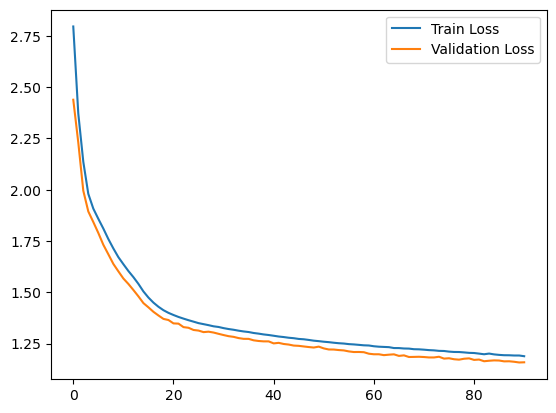

In [12]:
loss_values = np.array(loss_values)
plt.plot(loss_values[:, 0], label='Train Loss')
plt.plot(loss_values[:, 1], label='Validation Loss')
plt.legend()
plt.show()

## 5.4 模型评估

### 1.3 单输出模型评估-分类问题

Final Confusion Matrix:
 [[   1  180    9 ...    0    0    0]
 [   1  948  135 ...    0    0    0]
 [   0  255 1017 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]
Accuracy: 0.6636748518204911
F1 Score: 0.6435504271725697


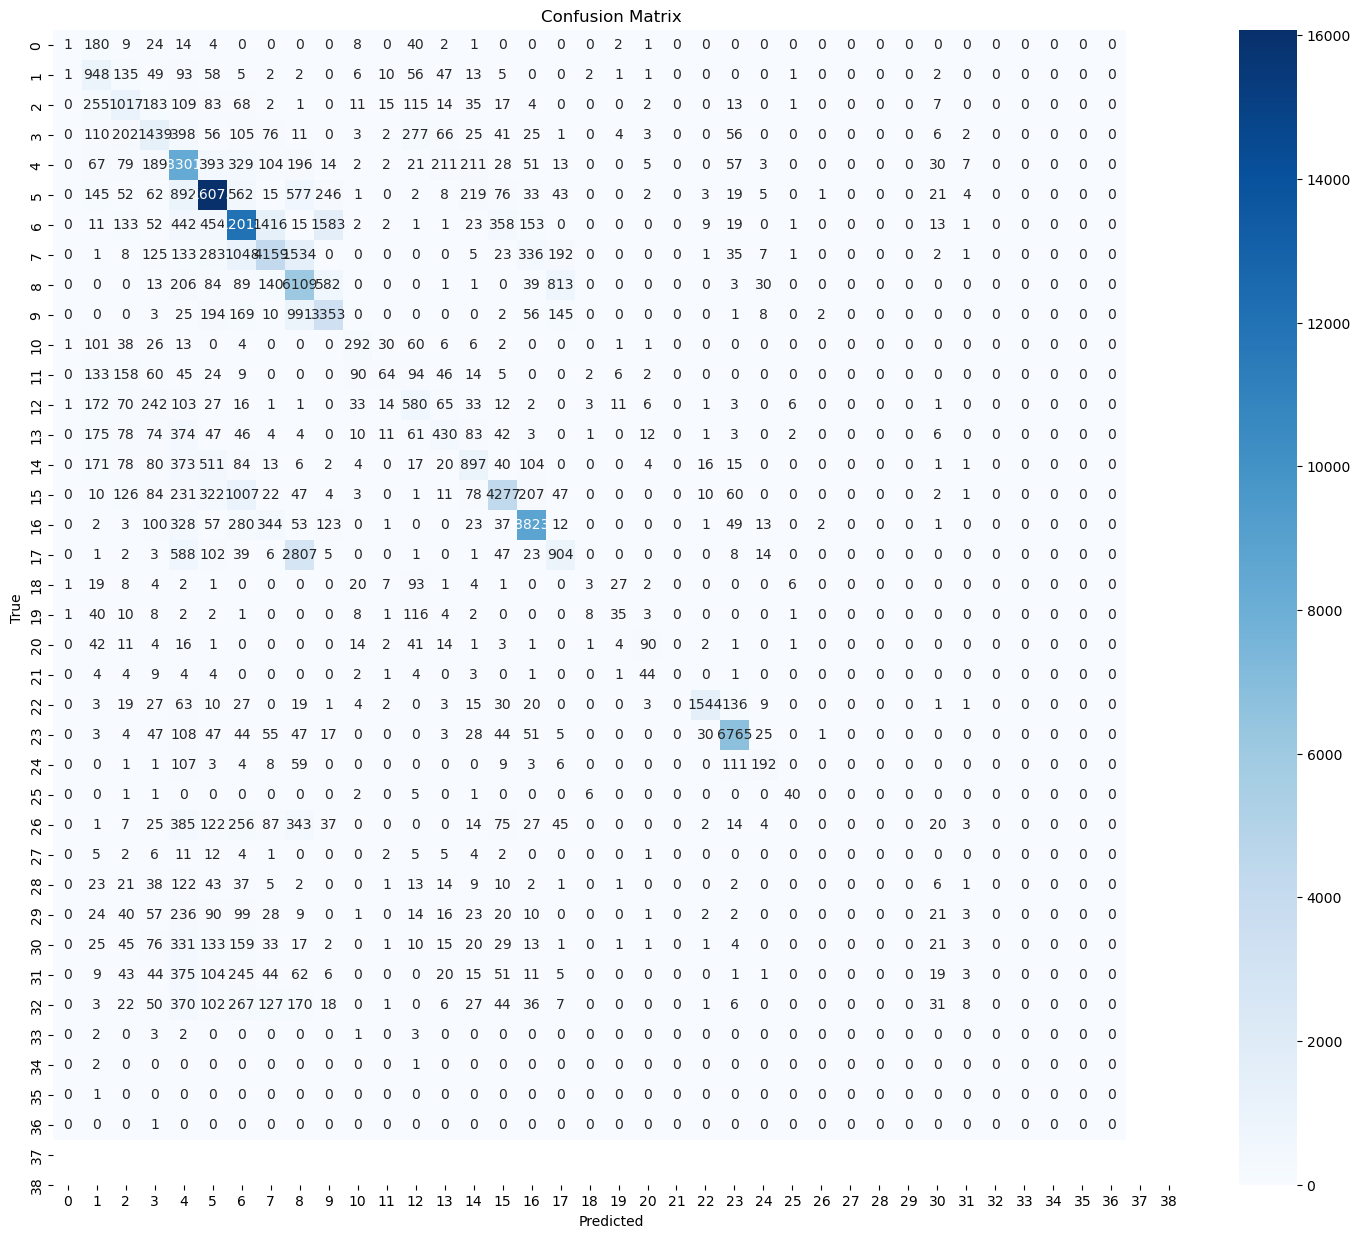

In [13]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

all_acc_scores = []
all_f1_scores = []
all_confusion_matrices = []
state_preds = []
state_targets = []

# 获取所有可能的类别数
num_state_classes = len(state_encoder.classes_)

with torch.no_grad():
    for x_val, y_state_val in test_loader:
        x_val = x_val.to(device).float()
        y_state_val = y_state_val.to(device).long()
        y_state_val = y_state_val.squeeze(-1)

        state_pred = model(x_val)
        state_preds.extend(torch.argmax(state_pred, dim=1).cpu().numpy())
        preds = torch.argmax(state_pred, dim=1).cpu().numpy()
        
        targets = y_state_val.cpu().numpy()
        state_targets.extend(y_state_val.cpu().numpy())

        # 计算当前批次的评估指标
        acc = accuracy_score(targets, preds)
        f1 = f1_score(targets, preds, average='weighted')
        
        # 确保混淆矩阵形状一致，指定所有可能的类别
        cm = confusion_matrix(targets, preds, labels=list(range(num_state_classes)))

        all_acc_scores.append(acc)
        all_f1_scores.append(f1)
        all_confusion_matrices.append(cm)

# 合并混淆矩阵
final_cm = sum(all_confusion_matrices)
print("Final Confusion Matrix:\n", final_cm)

# # 计算平均准确率和 F1 分数
# avg_acc = np.mean(all_acc_scores)
# avg_f1 = np.mean(all_f1_scores)
# print("Average Accuracy:", avg_acc)
# print("Average F1 Score:", avg_f1)

print("Accuracy:", accuracy_score(state_targets, state_preds))
print("F1 Score:", f1_score(state_targets, state_preds, average='weighted'))
#print("Confusion Matrix:\n", confusion_matrix(state_targets, state_preds))
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(state_targets, state_preds)
plt.figure(figsize=(18, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_state_classes), yticklabels=range(num_state_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### 2. 多输出模型评估 - 评估分类和回归任务


===== 状态分类评估 =====
准确率: 0.7088731202395677

===== 时间预测评估 =====
RMSE: 512.36
MAE: 189.42


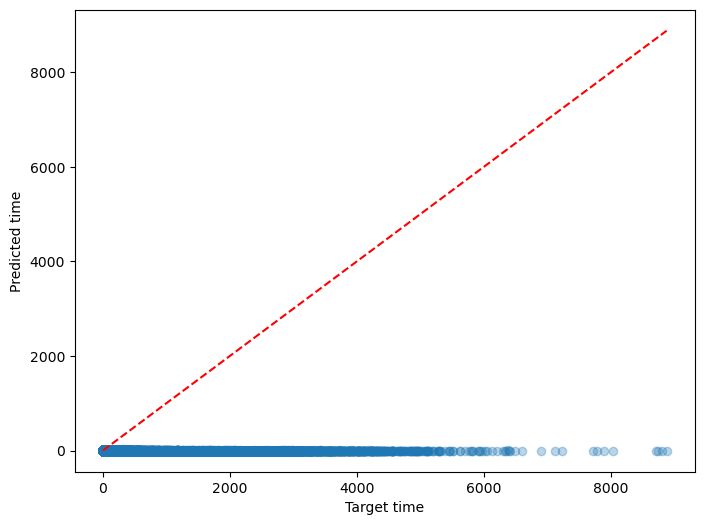

state_accuracy: 0.7088731202395677
time_rmse: 512.3604834513344
time_mae: 189.41597675696607


In [18]:
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 初始化存储容器
state_preds = []
time_preds = []
state_targets = []
time_targets = []
model.eval()

with torch.no_grad():
    for x_batch, y_state, y_time in test_loader:
        x_batch = x_batch.to(device).float()

        # 前向传播
        state_pred, time_pred = model(x_batch)

        # 收集预测结果
        state_preds.extend(torch.argmax(state_pred, dim=1).cpu().numpy())  # 取类别索引
        time_preds.extend(time_pred.cpu().numpy())

        # 收集真实标签
        state_targets.extend(y_state.cpu().numpy())
        time_targets.extend(y_time.cpu().numpy())

# ====== 分类任务评估 ======
print("\n===== 状态分类评估 =====")
print("准确率:", accuracy_score(state_targets, state_preds))
# print(classification_report(
#     state_targets, 
#     state_preds,
#     target_names=state_encoder.classes_  # 使用之前保存的编码器类别名
# ))


# ====== 时间回归评估 ======
print("\n===== 时间预测评估 =====")
rmse = np.sqrt(mean_squared_error(time_targets, time_preds))
mae = mean_absolute_error(time_targets, time_preds)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# 时间预测散点图
plt.figure(figsize=(8, 6))
plt.scatter(time_targets, time_preds, alpha=0.3)
plt.plot([min(time_targets), max(time_targets)], 
         [min(time_targets), max(time_targets)], 'r--')
plt.xlabel("Target time")
plt.ylabel("Predicted time")
plt.show()


print("state_accuracy:", accuracy_score(state_targets, state_preds))
print("time_rmse:", rmse)
print("time_mae:", mae)


